In [21]:
import sys

import networkx as nx
import igraph as ig
from networkx.generators.community import LFR_benchmark_graph

import numpy as np
import time

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18
plt.rcParams["lines.linewidth"] = 3

#sys.path.append("/home/oriol/Documents/Trento/JacobianGeometry/Code/Dynamics_v2/")
sys.path.append("/Users/giacomobarzon/Desktop/Network_geometry/Code_8thJune/Dynamics_v2/")
#sys.path.append("/home/barzon/Network_geometry/Code_8thJune/Dynamics_v2/")

import CommonFunctions as cf
import plotter

import importlib
importlib.reload(cf)
importlib.reload(plotter)

<module 'plotter' from '/Users/giacomobarzon/Desktop/Network_geometry/Code_8thJune/Dynamics_v2/plotter.py'>

# Graph generation

In [4]:
N = 60
mean_deg = 8

num_groups = 4; nodes_per_group = N//num_groups; kave = mean_deg; k_out = .15#kave is local average
k_in = kave - k_out
p_in = k_in/nodes_per_group
p_out = k_out/(nodes_per_group*num_groups - nodes_per_group)
print('Block model probs: in %f - out %f' % (p_in, p_out))

G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

while nx.is_connected(G_gn) == 0:
    print('The network should be in a single component. New trial!')
    G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

infoG_gn = ['GN',k_out]

print('Mean degree', np.mean(list(dict(G_gn.degree()).values())))

Block model probs: in 0.523333 - out 0.003333
Mean degree 7.3


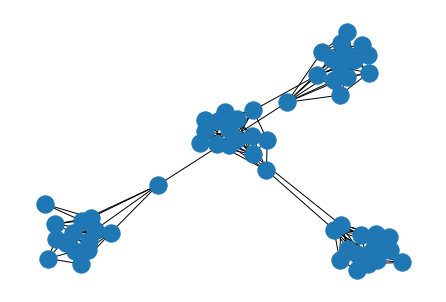

In [5]:
nx.draw(G_gn)

# Diffusive dynamics
$ \dot{x}_i = - B x_i + R k_i^{-1} \sum_j A_{ij} x_j $ <br>
$ J_{ij} = - B * \delta_{ij} + R * k_i^{-1} * A_{ij} $<br>
<br>
if B=R=1 -> $J_{ij}=-L_{ij}$<br>
<br>
$ \lambda_{max} = -B$<br>
$ \lambda_{min} = -(B-R)$<br>
stable only if $\lambda_{min}<0 -> B>R$

In [6]:
def Simu_diffu_params(G, infoG, params, t_max = 1, t_n = 1):
    """
    Inputs: Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
            dynamic (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            kwargs: parameters of model
    """
    print('-------- GRAPH DISTANCES --------')
    start_time = time.time()
    
    num_nodes = G.number_of_nodes()
    #num_time_points = 50 # small to decrease computational load
    times_perturbation = np.linspace(0, t_max*num_nodes, num = (num_nodes+1)*t_n) #times at which we look how the perturbation evolves
    
    if nx.is_connected(G) == 0:
        raise ValueError('The network should be in a single component. Exit!')
    
    dist_t = []
    avg_dist_t = []
    eigvals = []
    
    for param in params:
        ### DIFFUSION
        print('[*] DIFFUSION DISTANCE - PARAMS: '+str(param))
        # analytical expression of diffusion
        print('Evaluating jacobian distance...')
        tmp_d = cf.Laplacian(nx.to_numpy_array(G), times_perturbation, A=param[0], B=param[1], return_snapshot=True)
        
        dist_t.append(tmp_d[0])
        avg_dist_t.append(tmp_d[1])
        eigvals.append(tmp_d[2])
    
    return dist_t, avg_dist_t, eigvals, times_perturbation

In [141]:
# Define parameters
param_1 = [0.1, 0.5, 1., 2., 5.]
param_2 = [0.1, 0.5, 1., 2., 5.]
params = [[a, b] for a in param_1 for b in param_2]

param_1_name = 'B'
param_2_name = 'R'
params_name = [param_1_name+'='+str(a)+','+param_2_name+'='+str(b) for a in param_1 for b in param_2]
params_rows = [param_1_name+'='+str(a) for a in param_1]
params_cols = [param_2_name+'='+str(b) for b in param_2]

In [142]:
dist_t, avg_dist_t, eigvals, times = Simu_diffu_params(G_gn, infoG_gn, params)

-------- GRAPH DISTANCES --------
[*] DIFFUSION DISTANCE - PARAMS: [0.1, 0.1]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.1, 0.5]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.1, 1.0]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.1, 2.0]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.1, 5.0]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.1]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.5]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 1.0]
Evaluating jacobian distance...


KeyboardInterrupt: 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


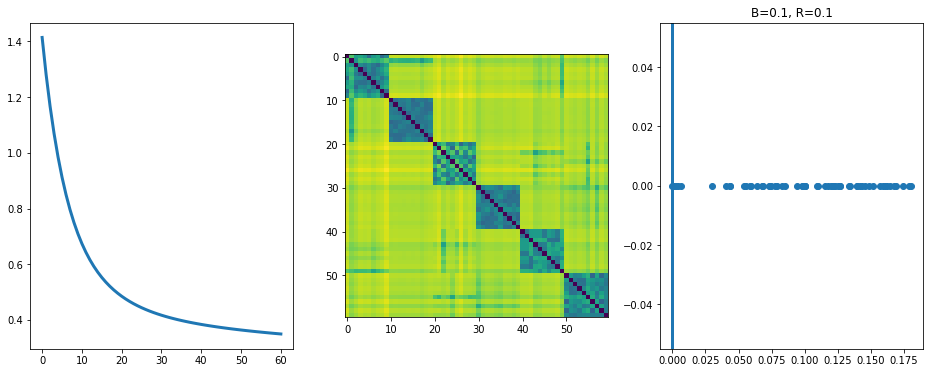

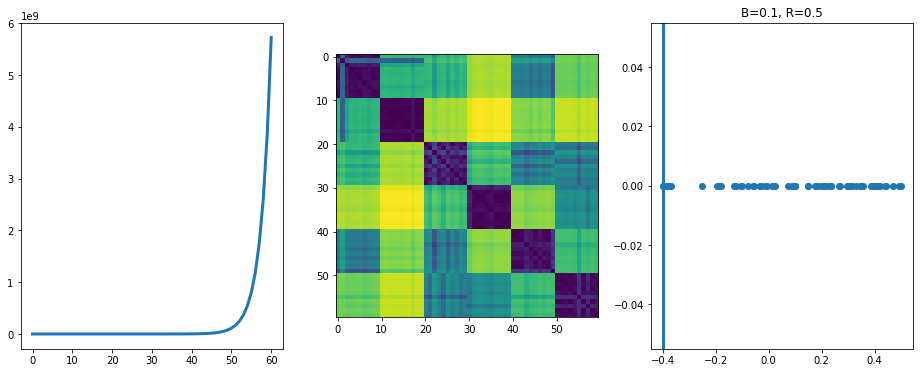

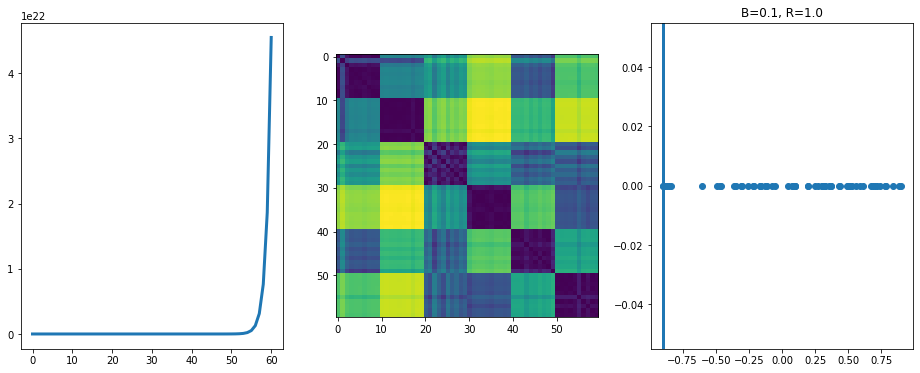

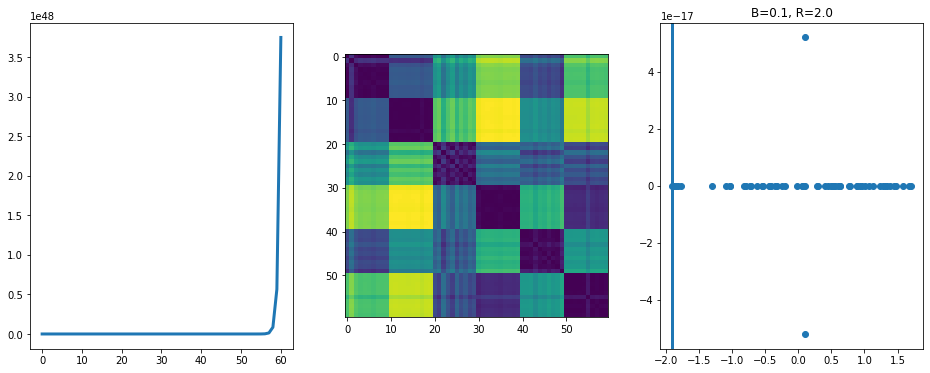

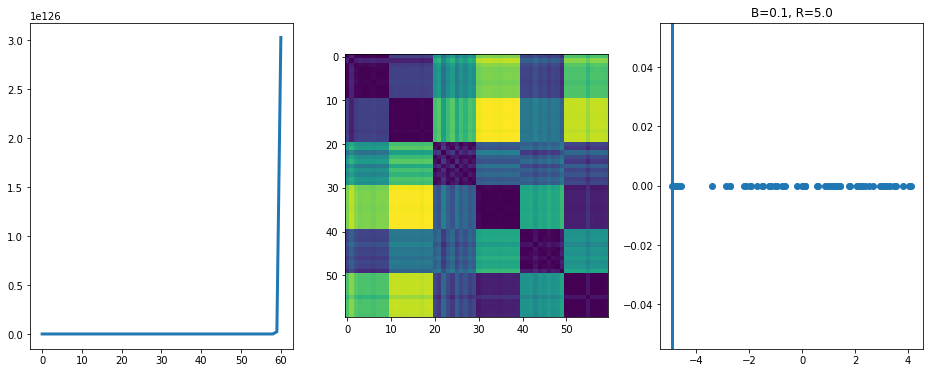

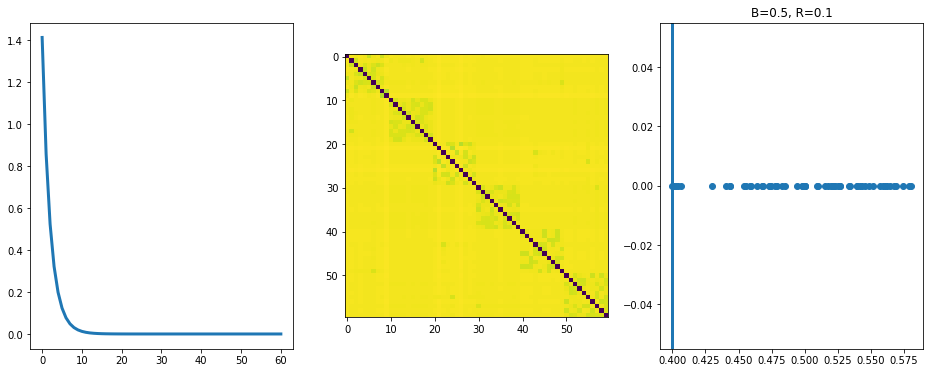

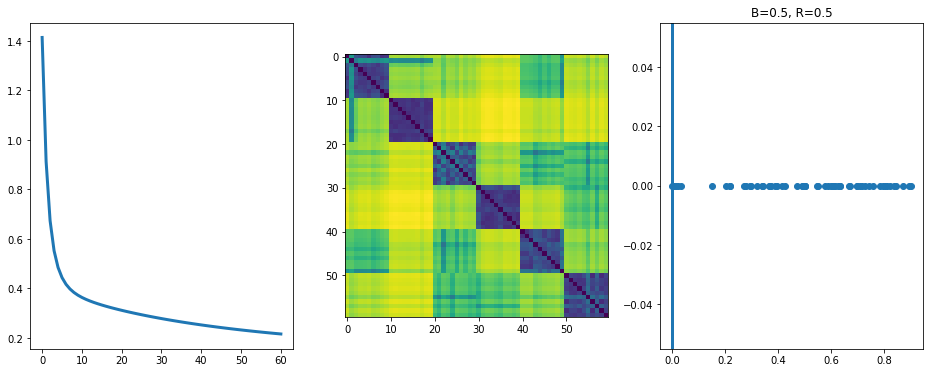

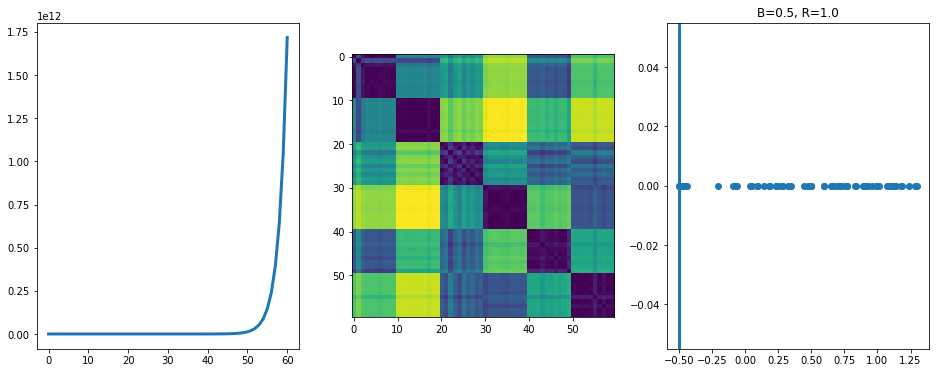

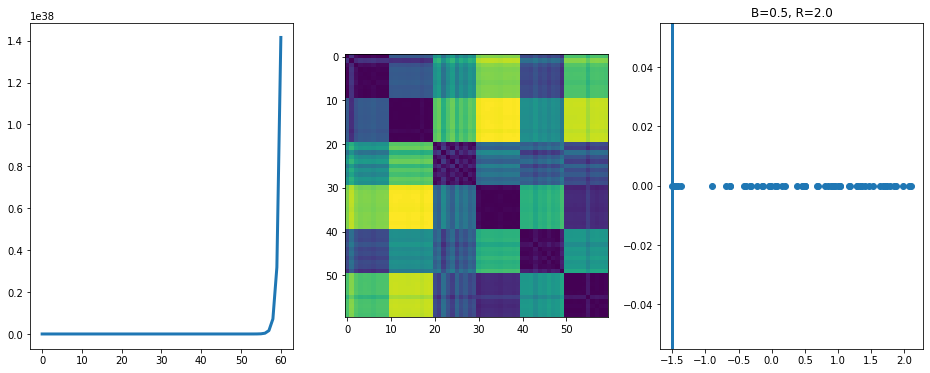

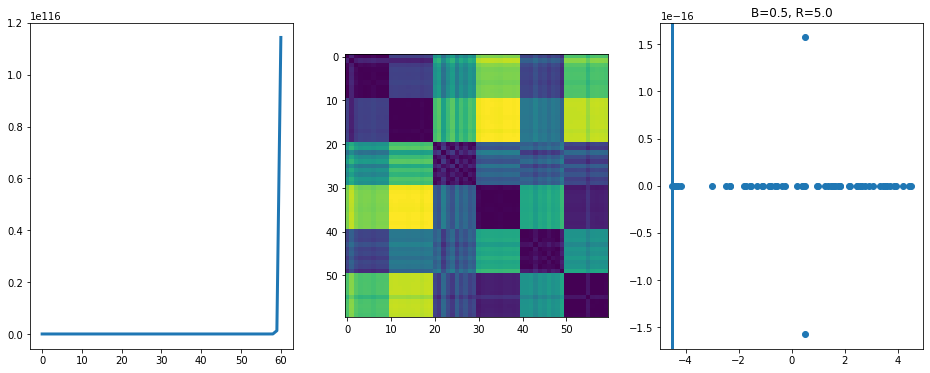

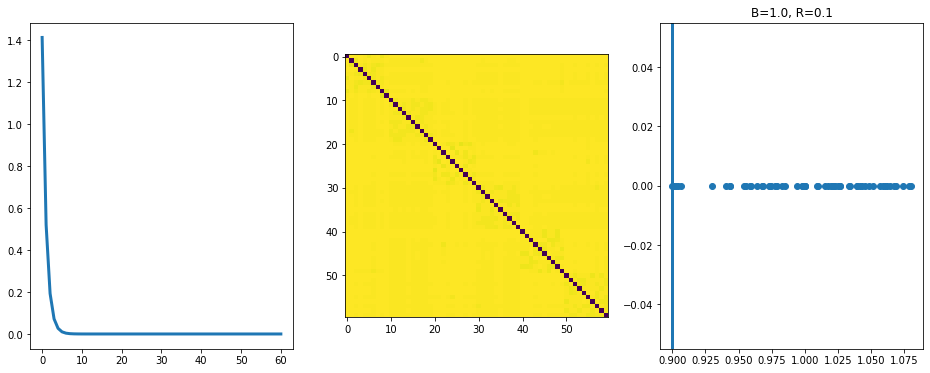

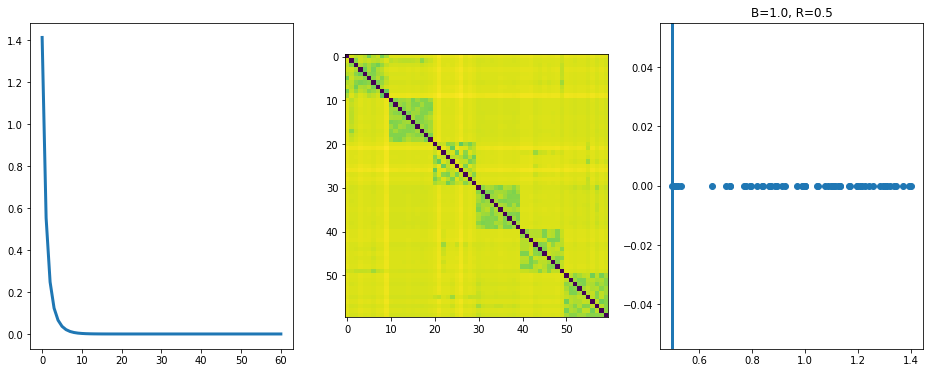

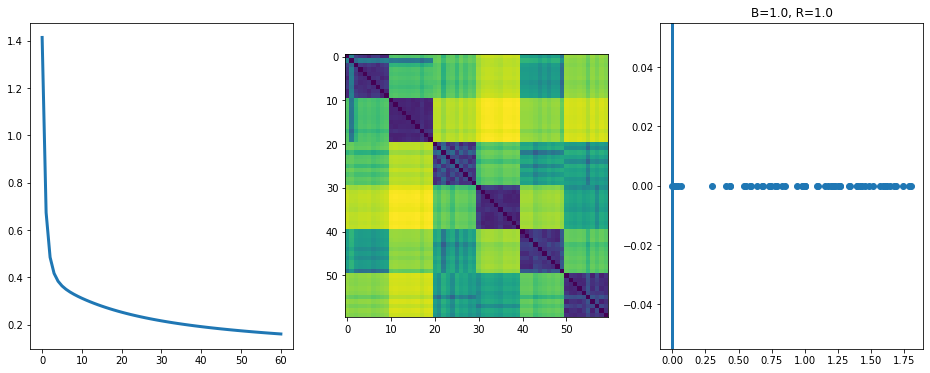

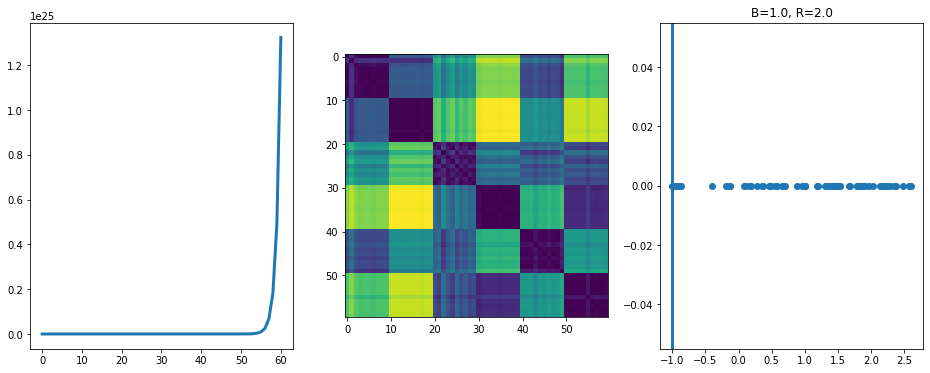

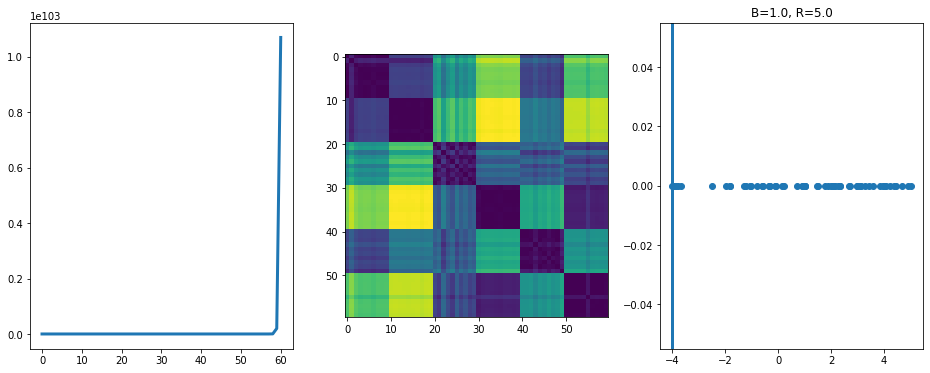

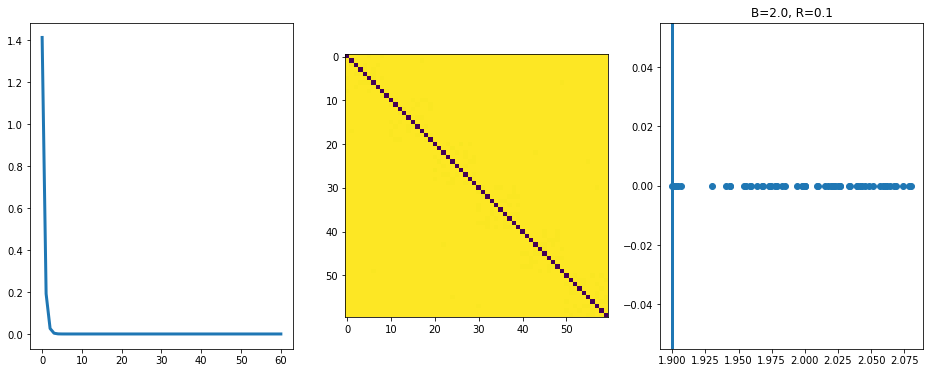

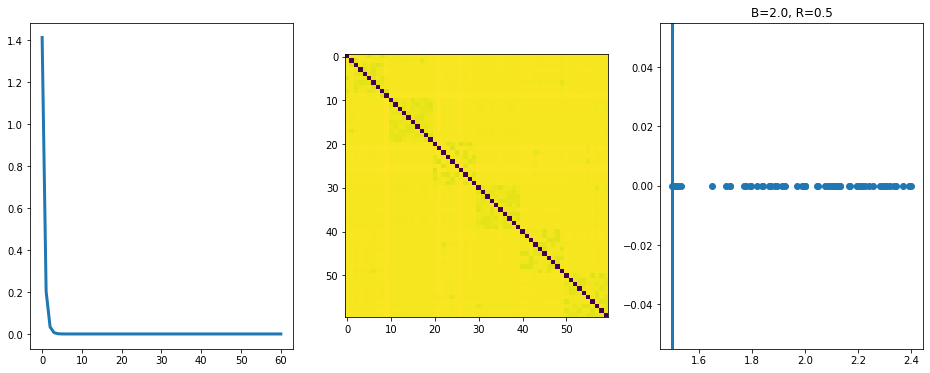

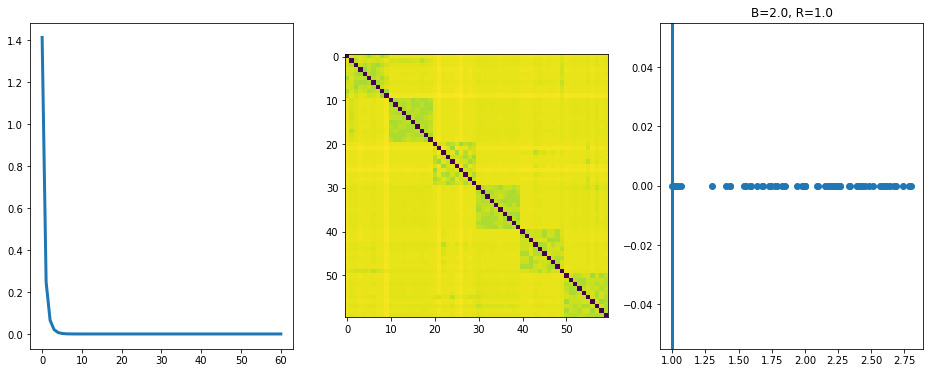

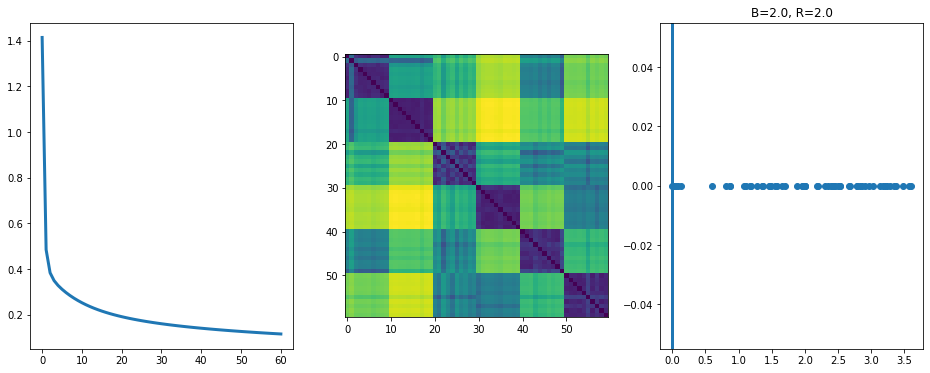

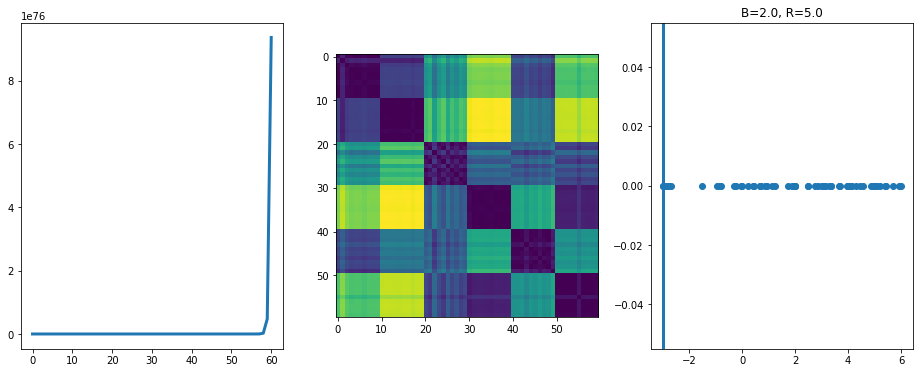

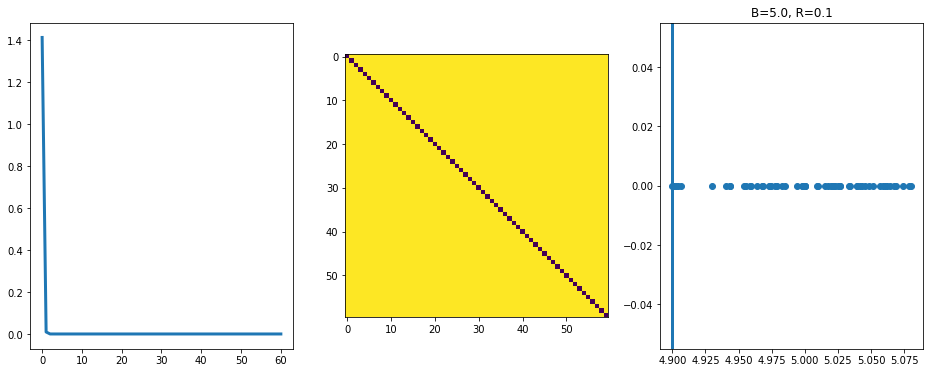

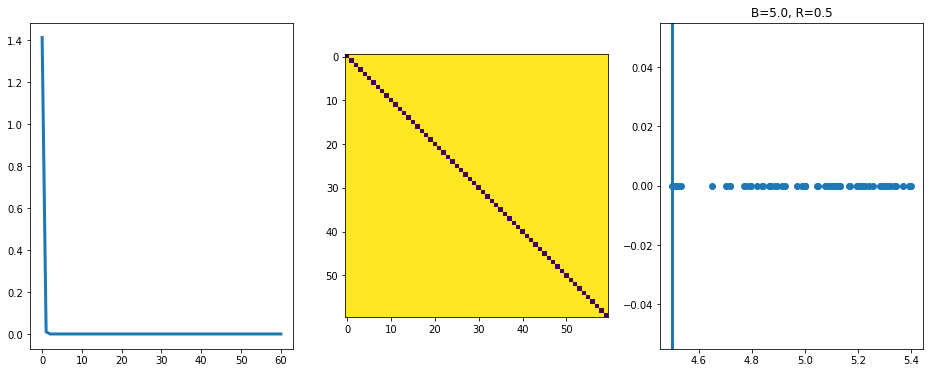

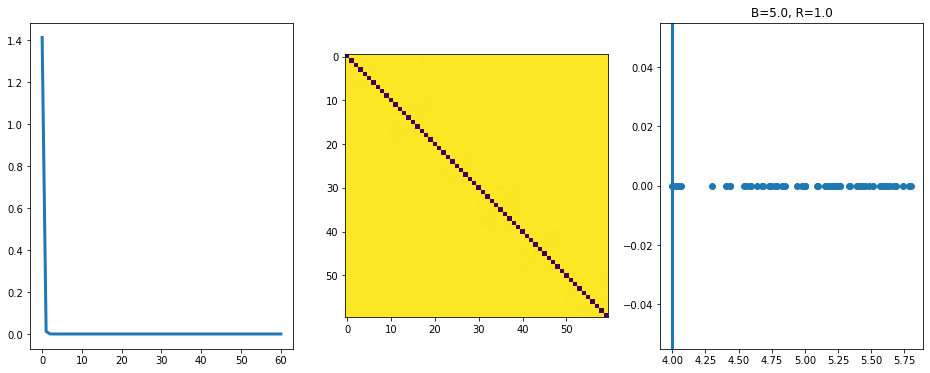

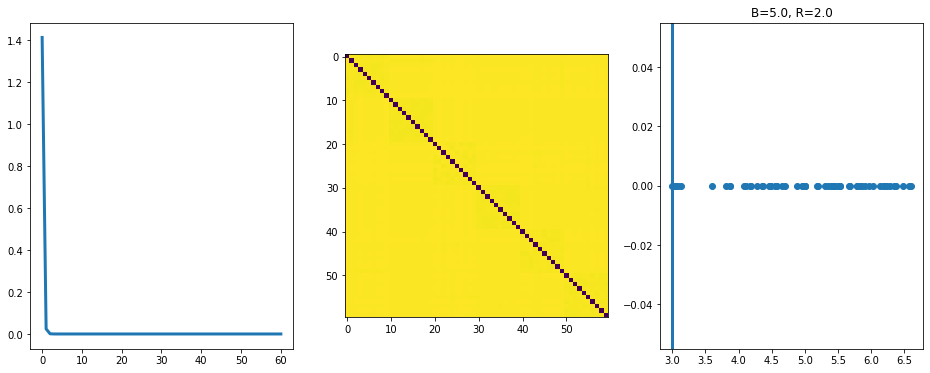

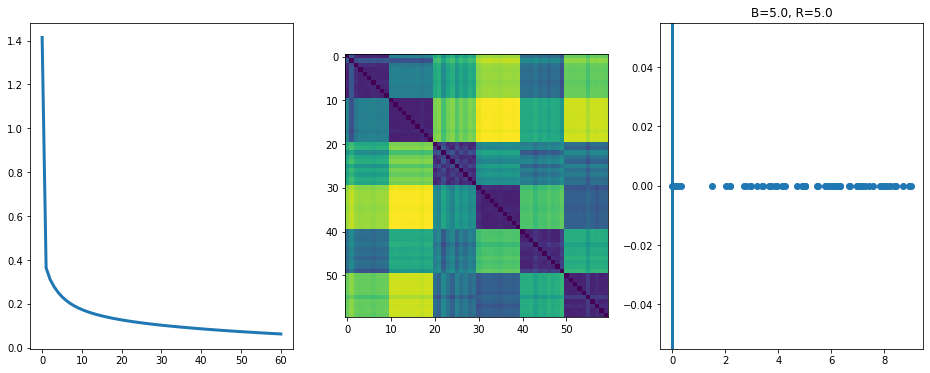

In [57]:
for i, param in enumerate(params):
    plt.figure(figsize=(16,6))
    
    ### Average distance vs time
    plt.subplot(1,3,1)
    plt.plot(times, dist_t[i])
    
    ### Average distance matrix
    plt.subplot(1,3,2)
    plt.imshow(cf.get_average_distance_matrix(avg_dist_t[i]))
    
    ### Eigvals
    plt.subplot(1,3,3)
    plt.plot(eigvals[i].real, eigvals[i].imag, 'o')
    plt.axvline(param[0]-param[1])
    
    plt.title('B='+str(param[0])+', R='+str(param[1]))
    
plt.show()

### Varying B

In [143]:
params_b = [0.2, 0.4, 0.6, 0.8, 1.]
params_a = [0.2, 0.5, 1.]
params = [[a, a*b] for a in params_a for b in params_b]

dist_t, avg_dist_t, eigvals, times = Simu_diffu_params(G_gn, infoG_gn, params)

-------- GRAPH DISTANCES --------
[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.04000000000000001]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.08000000000000002]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.12]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.16000000000000003]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.1]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.3]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.4]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.5]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.4]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.6]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.8]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 1.0]
Evaluating jacobian distance...


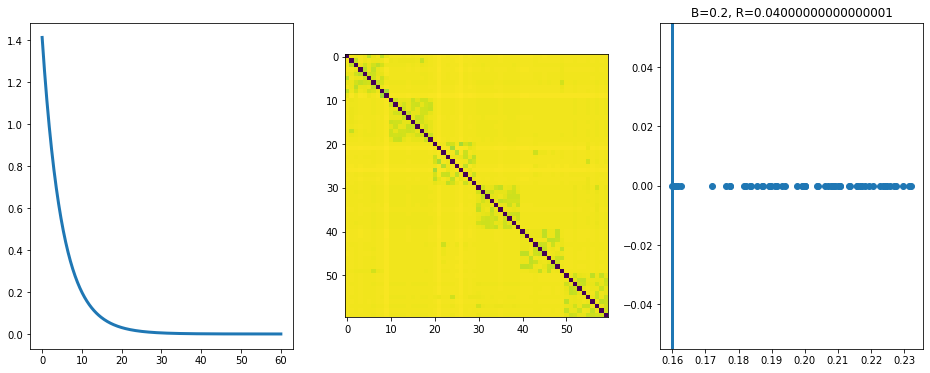

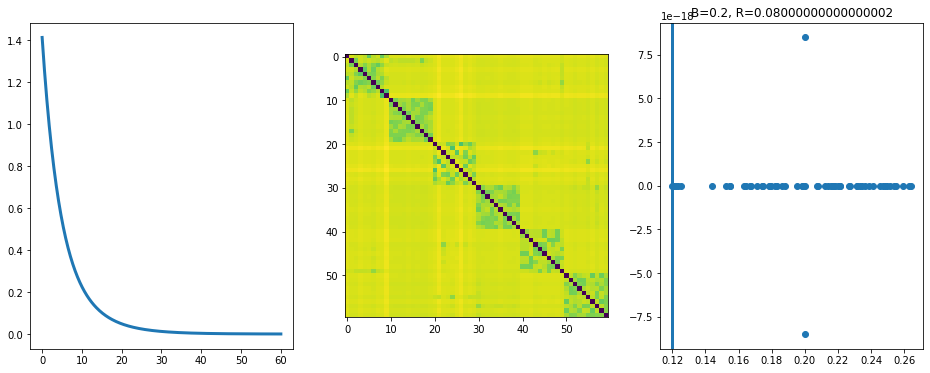

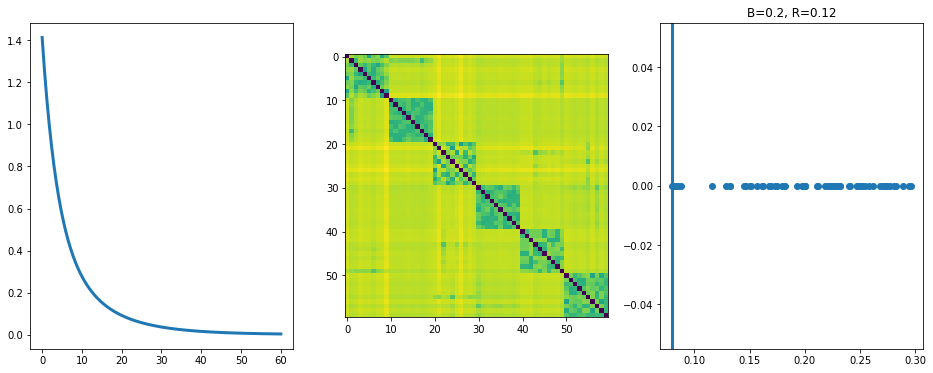

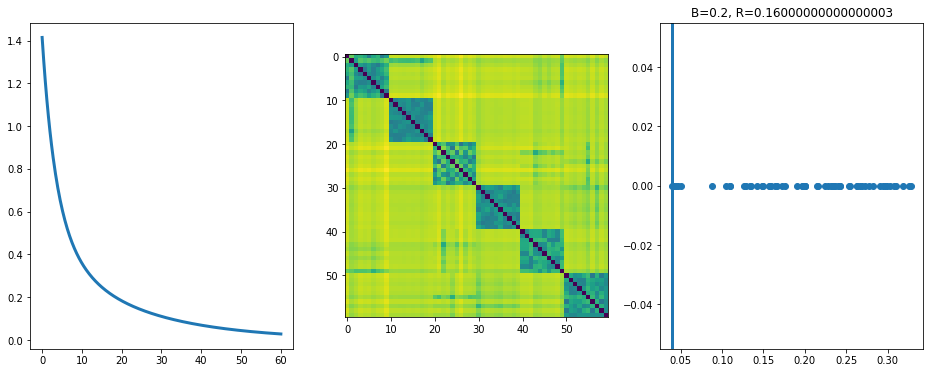

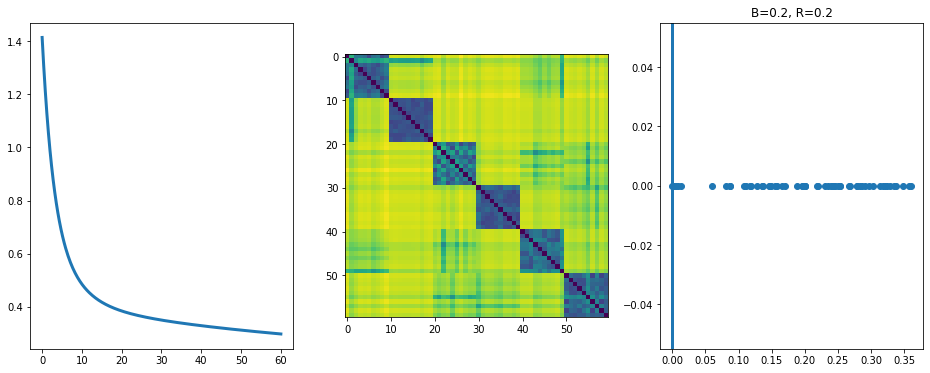

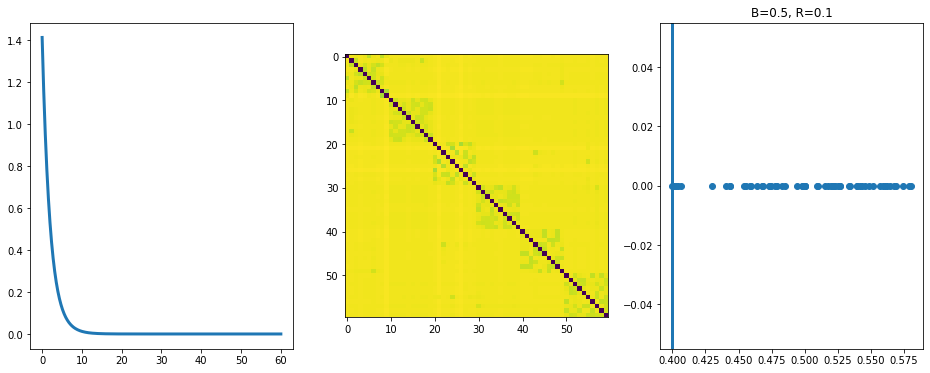

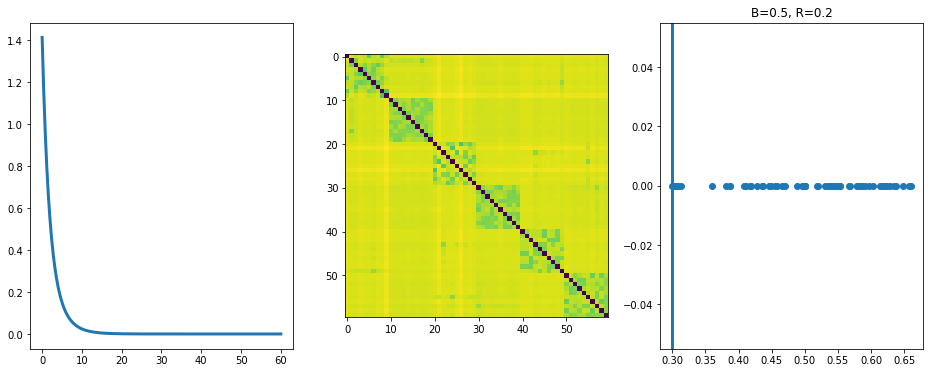

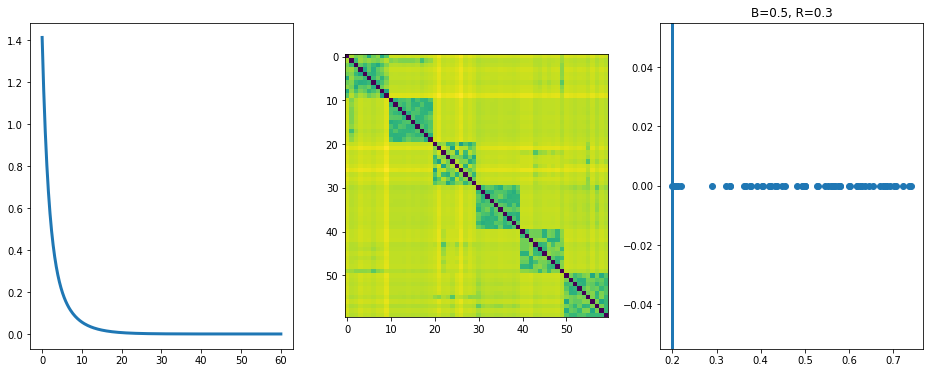

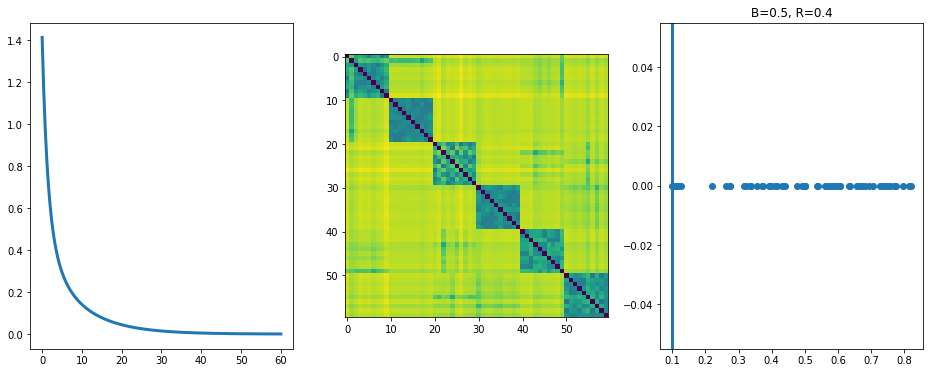

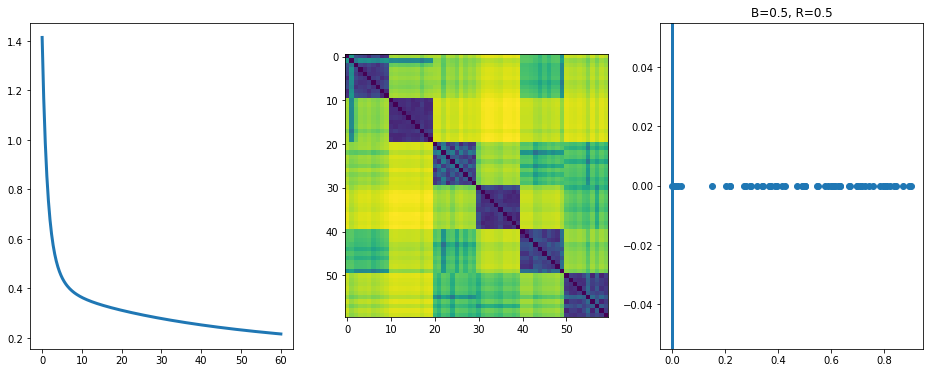

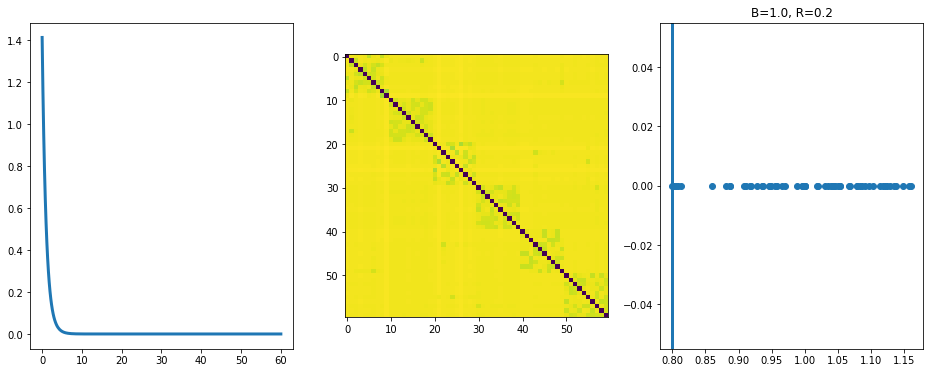

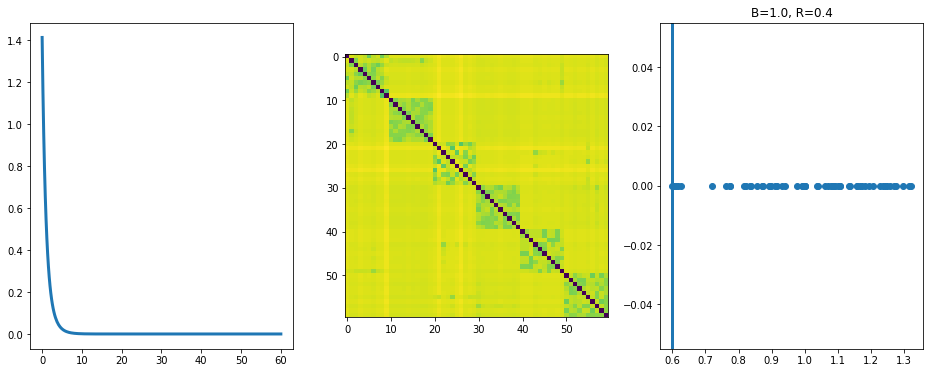

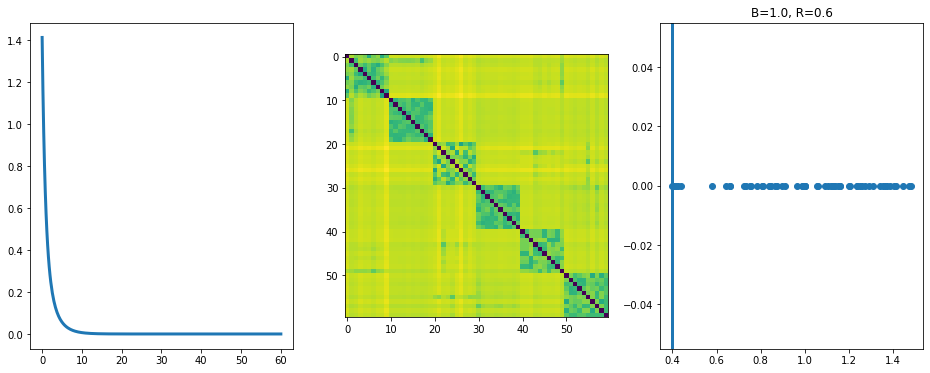

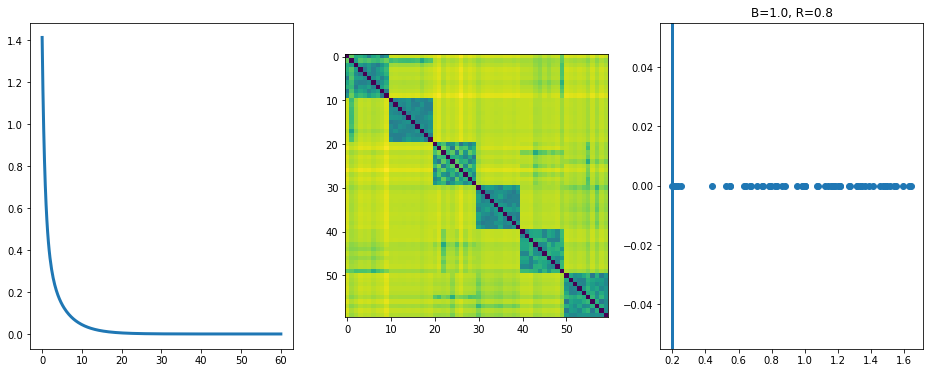

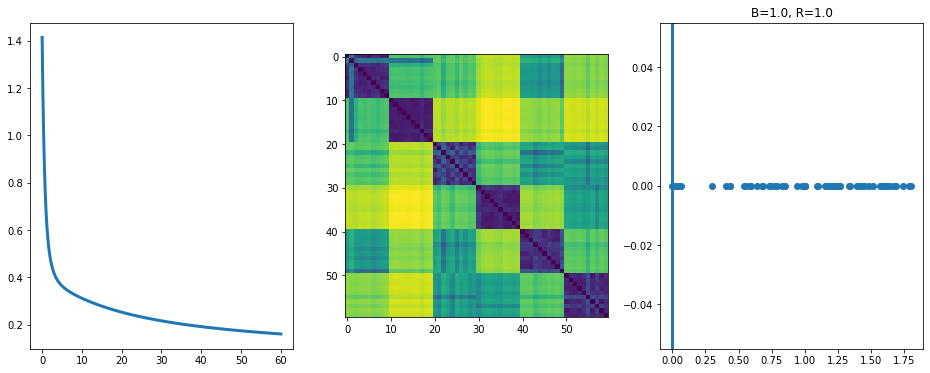

In [63]:
for i, param in enumerate(params):
    plt.figure(figsize=(16,6))
    
    ### Average distance vs time
    plt.subplot(1,3,1)
    plt.plot(times, dist_t[i])
    
    ### Average distance matrix
    plt.subplot(1,3,2)
    plt.imshow(cf.get_average_distance_matrix(avg_dist_t[i]))
    
    ### Eigvals
    plt.subplot(1,3,3)
    plt.plot(eigvals[i].real, eigvals[i].imag, 'o')
    plt.axvline(param[0]-param[1])
    
    plt.title('B='+str(param[0])+', R='+str(param[1]))
    
plt.show()

TypeError: expected non-empty vector for x

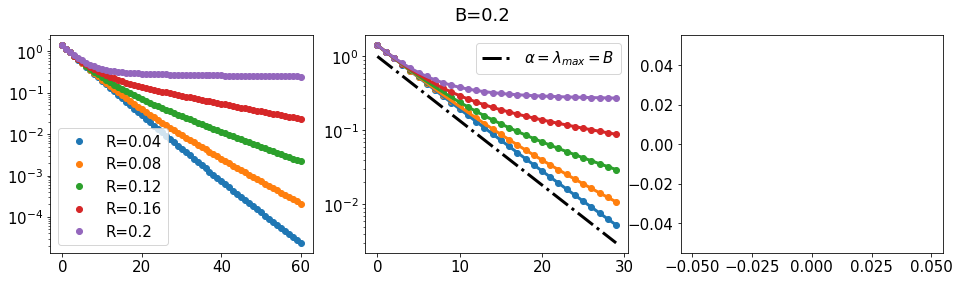

In [144]:
T = 30
K = 180

for k, A in enumerate(params_a):

    plt.figure(figsize=(16,4))

    plt.subplot(1,3,1)

    plt.suptitle('B='+str(A))

    for i in range(k*5, (k+1)*5):
        plt.plot(times, dist_t[i], 'o', label='R='+str(round(params[i][1],2)))
    
        plt.yscale('log')
    
        plt.legend()
    
    plt.subplot(1,3,2)

    for i in range(k*5, (k+1)*5):
        plt.plot(times[:T], dist_t[i][:T])
        plt.scatter(times[:T], dist_t[i][:T])
    
        plt.yscale('log')
        
    plt.plot(times[:T], np.exp(-times[:T]*A), '-.', c='k', label=r'$\alpha=\lambda_{max}=B$')
    plt.legend()
    
    plt.subplot(1,3,3)

    for i in range(k*5, (k+1)*5):
        plt.plot(times[K:], dist_t[i][K:])
        plt.scatter(times[K:], dist_t[i][K:])
        
        coef = np.polyfit(times[K:], np.log(dist_t[i][K:]), deg=1)
        
        if i==k*5:
            plt.plot(times[K:], np.exp(coef[1])*np.exp(-times[K:]*eigvals[i][0].real), '-.', c='k', zorder=10, label=r'$\alpha=\lambda_{min}=B-R$')
        else:
            plt.plot(times[K:], np.exp(coef[1])*np.exp(-times[K:]*eigvals[i][0].real), '-.', c='k', zorder=10)
            
        plt.yscale('log')
    plt.legend()
    
plt.show()

In [65]:
for i, dist in enumerate(dist_t[:5]):
    coef = np.polyfit(times[K:], np.log(dist[K:]), deg=1)
    print("B = "+str(params_b[i])+', Coef = '+str(-coef[0]))

B = 0.2, Coef = 0.16926313605630705
B = 0.4, Coef = 0.12577356048833388
B = 0.6, Coef = 0.08467223574082207
B = 0.8, Coef = 0.04469161801999874
B = 1.0, Coef = 0.005106511459438029


### Try with another network...

In [13]:
param_2 = [0.2, 0.4, 0.6, 0.8, 1.]
param_1 = [0.2, 0.5, 1.]
params = [[a, a*b] for a in param_1 for b in param_2]

param_1_name = 'B'
param_2_name = 'R/B'
params_name = [param_1_name+'='+str(a)+','+param_2_name+'='+str(b) for a in param_1 for b in param_2]
params_rows = [param_1_name+'='+str(a) for a in param_1]
params_cols = [param_2_name+'='+str(b) for b in param_2]

dist_t, avg_dist_t, eigvals, times = Simu_diffu_params(G_gn, infoG_gn, params, t_max = 2, t_n = 5)

-------- GRAPH DISTANCES --------
[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.04000000000000001]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.08000000000000002]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.12]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.16000000000000003]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.1]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.3]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.4]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.5]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.4]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.6]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.8]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 1.0]
Evaluating jacobian distance...


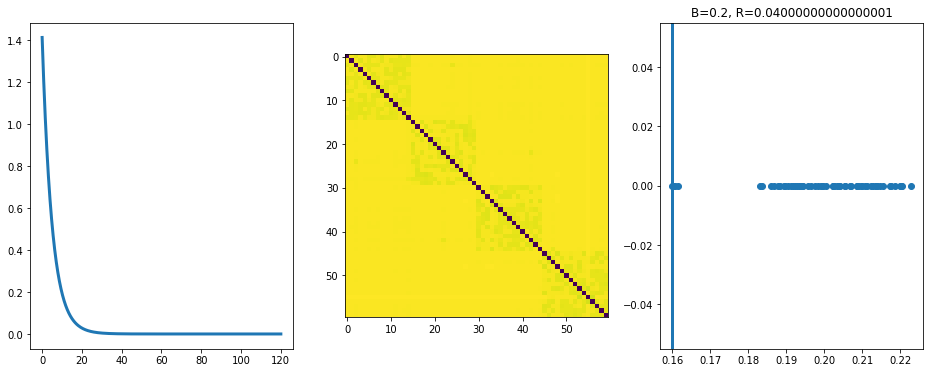

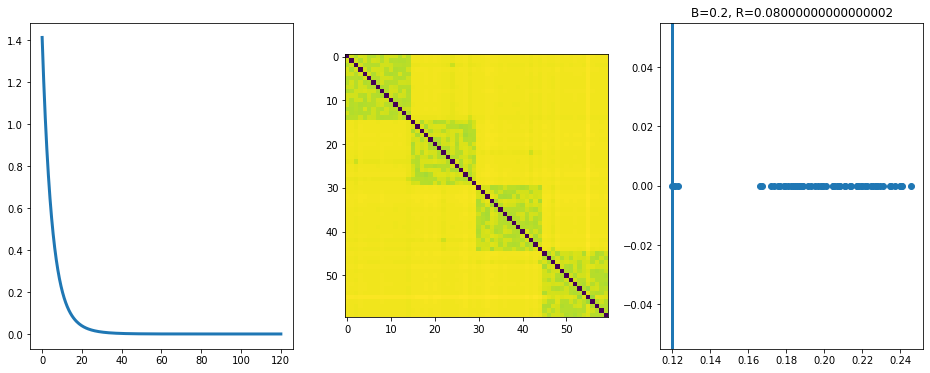

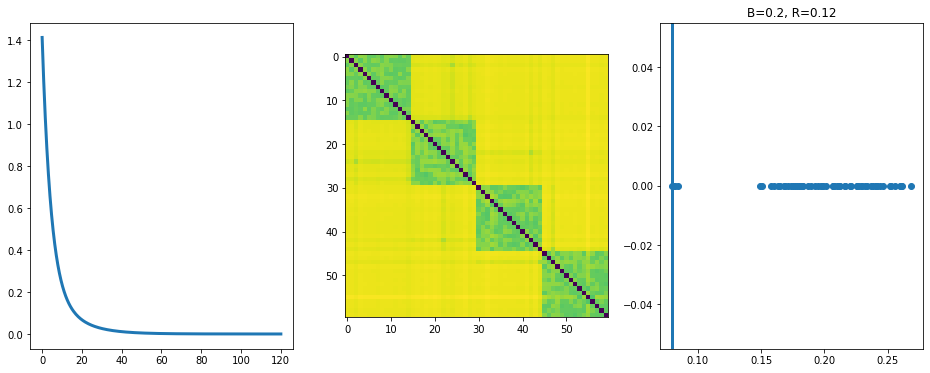

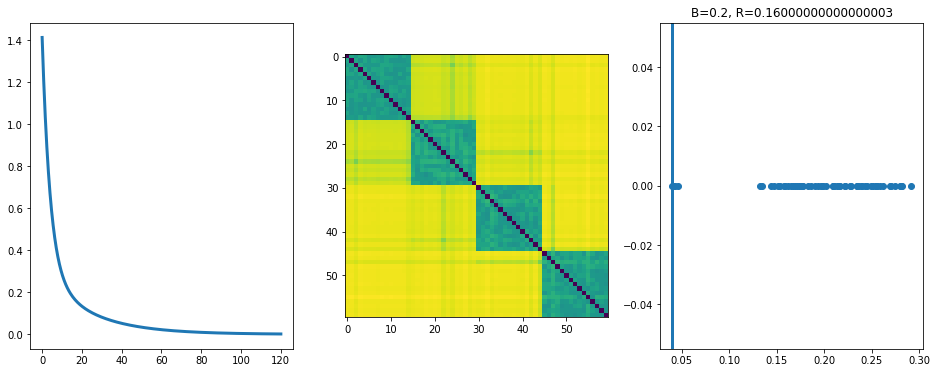

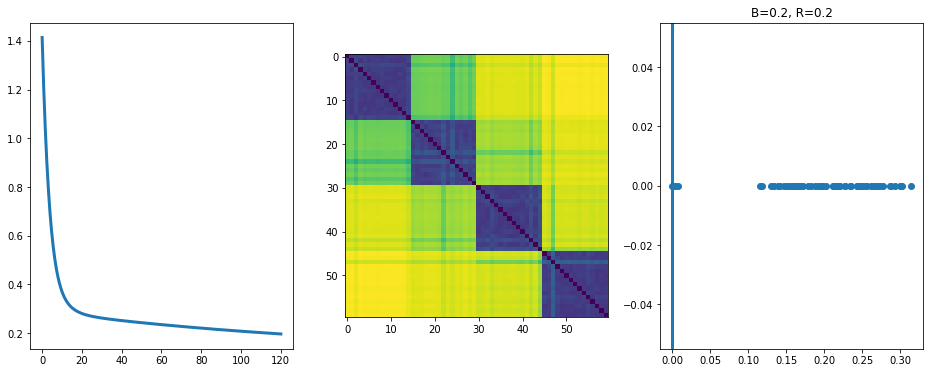

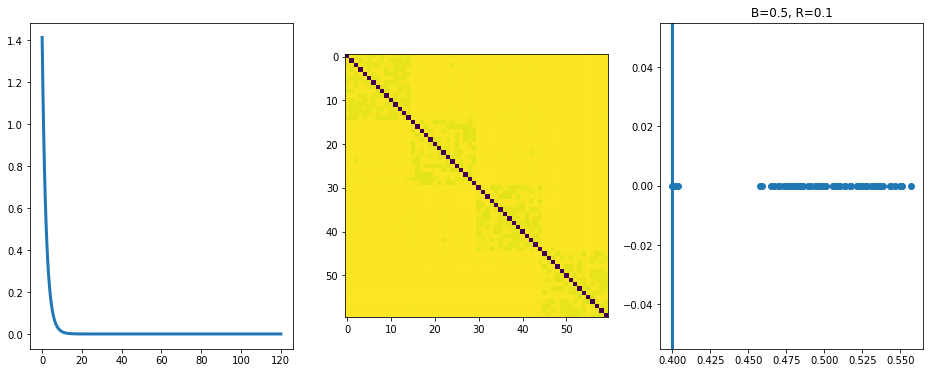

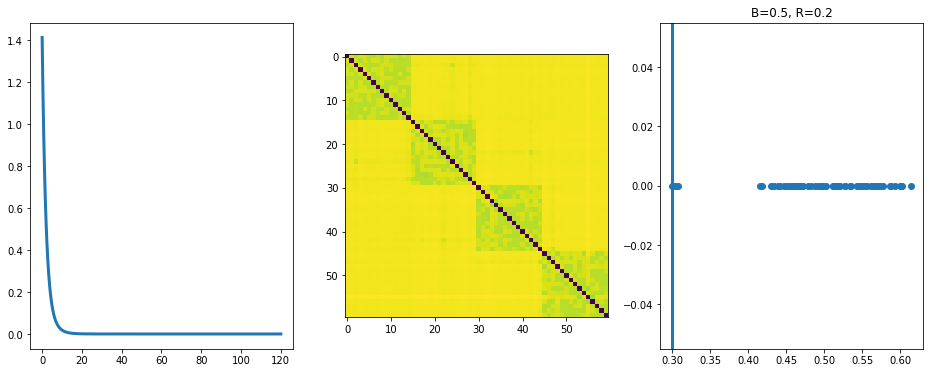

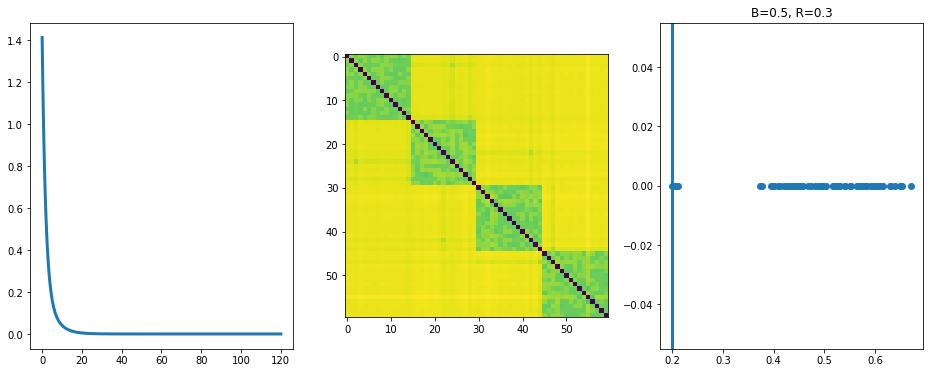

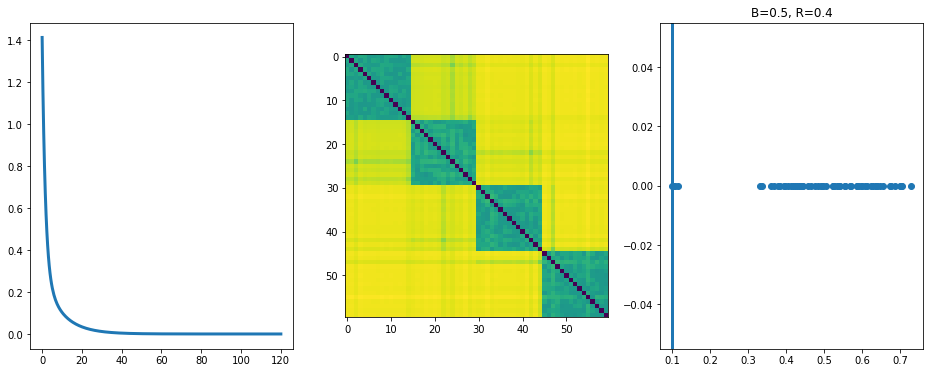

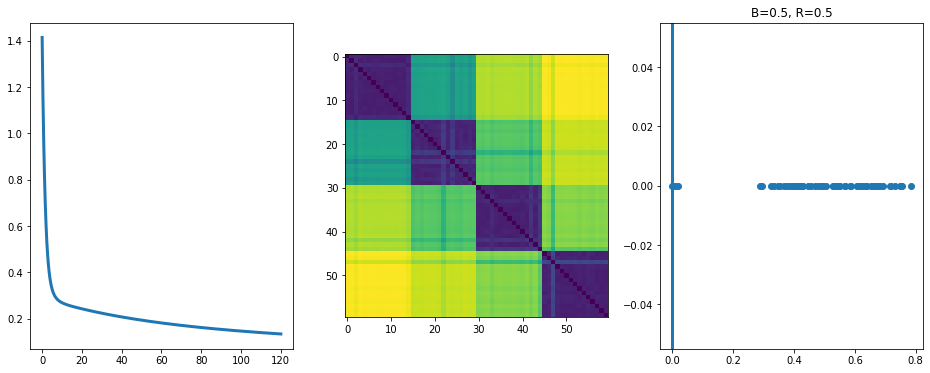

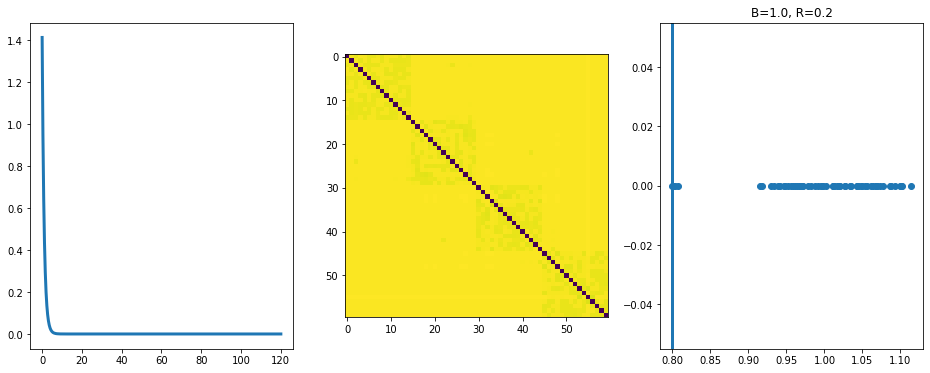

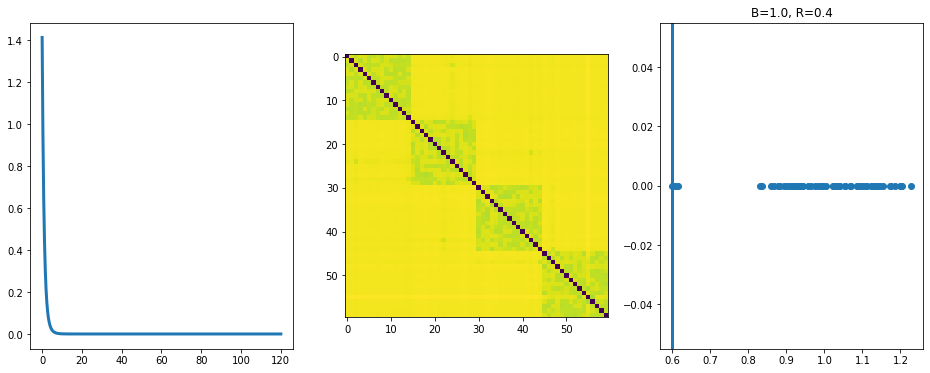

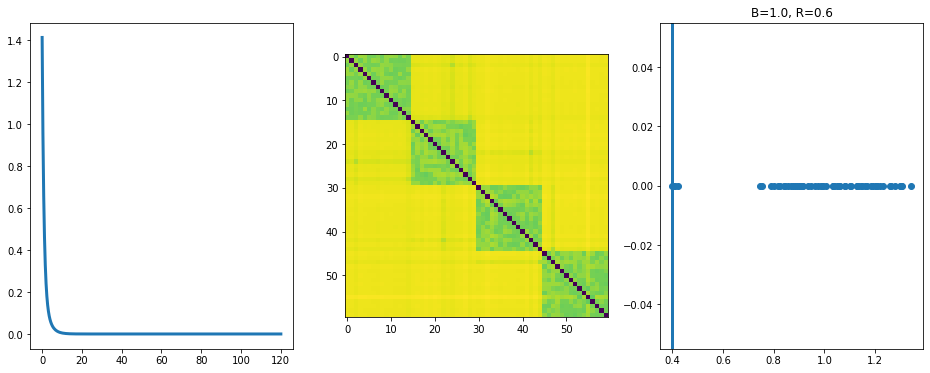

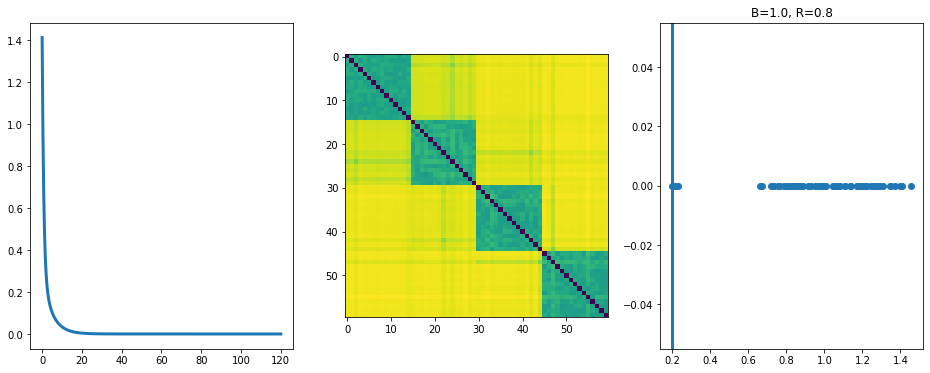

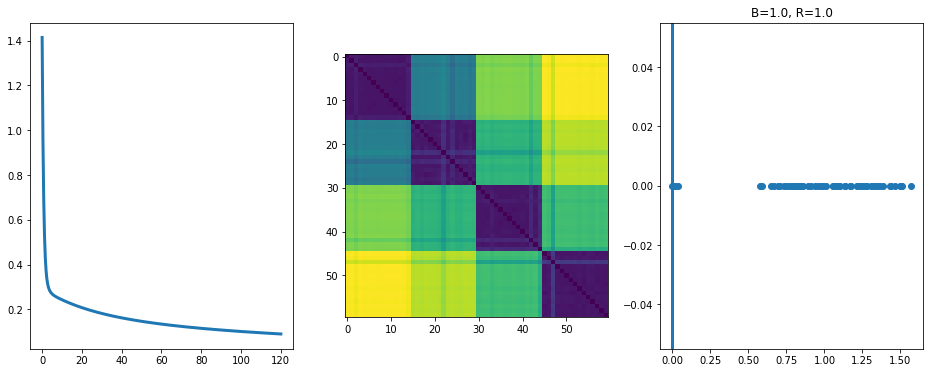

In [14]:
for i, param in enumerate(params):
    plt.figure(figsize=(16,6))
    
    ### Average distance vs time
    plt.subplot(1,3,1)
    plt.plot(times, dist_t[i])
    
    ### Average distance matrix
    plt.subplot(1,3,2)
    plt.imshow(cf.get_average_distance_matrix(avg_dist_t[i]))
    
    ### Eigvals
    plt.subplot(1,3,3)
    plt.plot(eigvals[i].real, eigvals[i].imag, 'o')
    plt.axvline(param[0]-param[1])
    
    plt.title('B='+str(param[0])+', R='+str(param[1]))
    
plt.show()

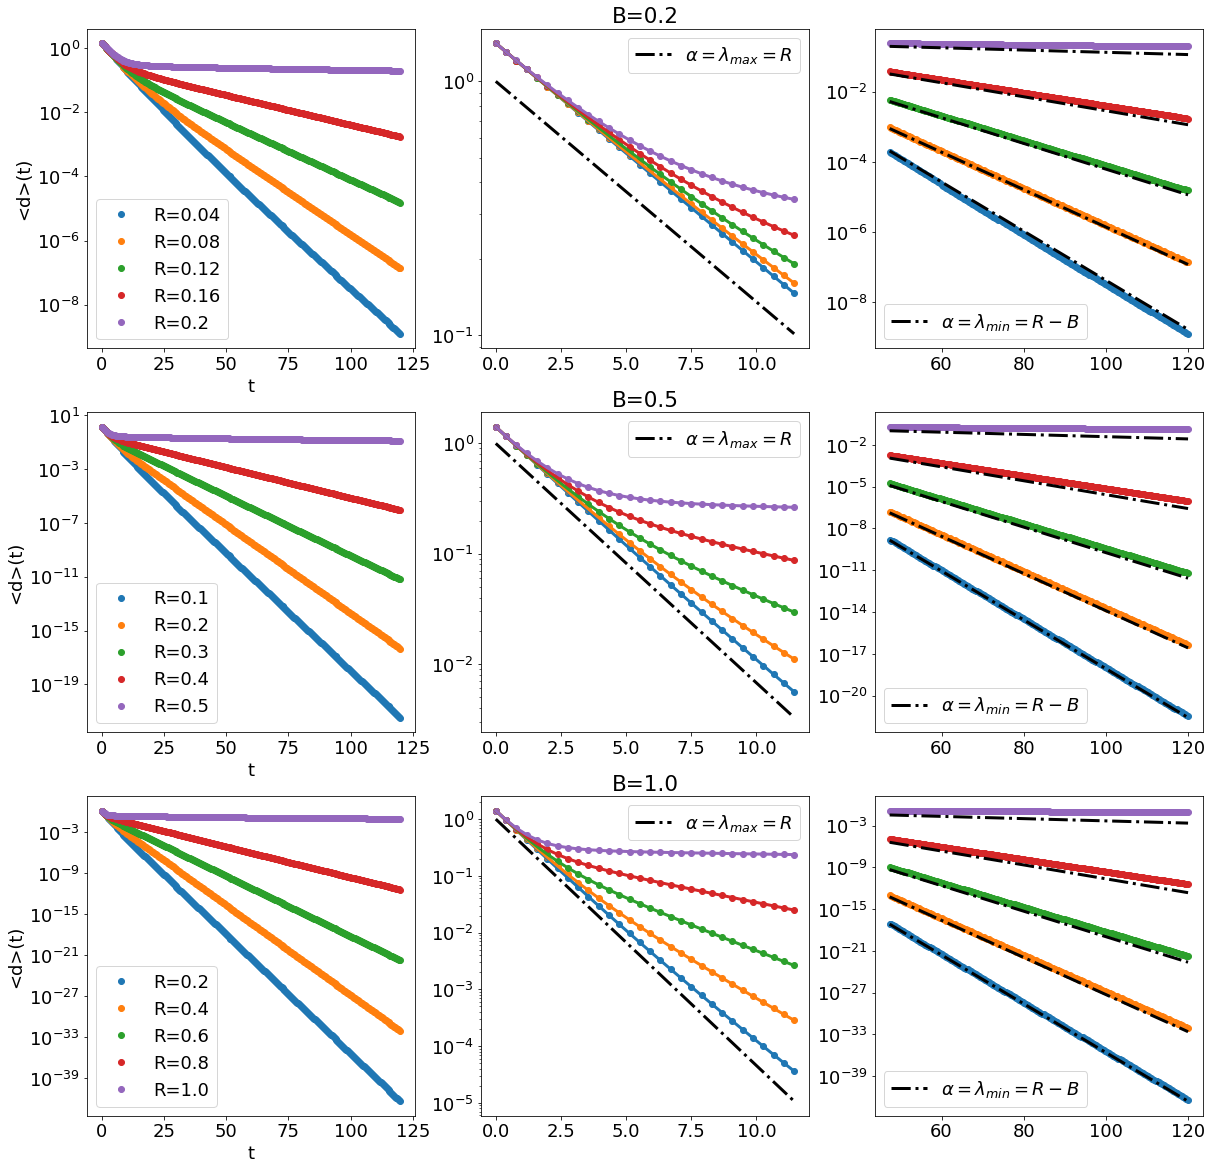

In [34]:
T = 30
K = 120

plt.figure(figsize=(20,20))

for k, A in enumerate(param_1):

    plt.subplot(3,3,k*3+1)

    for i in range(k*5, (k+1)*5):
        plt.plot(times, dist_t[i], 'o', label='R='+str(round(params[i][1],2)))
    
        plt.yscale('log')
        
    plt.xlabel('t')
    plt.ylabel('<d>(t)')
    plt.legend()
    
    plt.subplot(3,3,k*3+2)
    
    plt.title('B='+str(A))

    for i in range(k*5, (k+1)*5):
        plt.plot(times[:T], dist_t[i][:T])
        plt.scatter(times[:T], dist_t[i][:T])
    
        plt.yscale('log')
        
    plt.plot(times[:T], np.exp(-times[:T]*A), '-.', c='k', label=r'$\alpha=\lambda_{max}=R$')
    plt.legend()
    
    plt.subplot(3,3,k*3+3)

    for i in range(k*5, (k+1)*5):
        plt.plot(times[K:], dist_t[i][K:])
        plt.scatter(times[K:], dist_t[i][K:])
        
        coef = np.polyfit(times[K:], np.log(dist_t[i][K:]), deg=1)
        
        if i==k*5:
            plt.plot(times[K:], np.exp(coef[1])*np.exp(-times[K:]*eigvals[i][0].real), '-.', c='k', zorder=10, label=r'$\alpha=\lambda_{min}=R-B$')
        else:
            plt.plot(times[K:], np.exp(coef[1])*np.exp(-times[K:]*eigvals[i][0].real), '-.', c='k', zorder=10)
            
        plt.yscale('log')
    plt.legend()
    
plt.show()

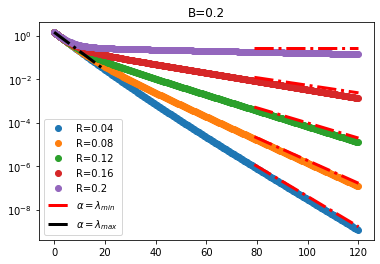

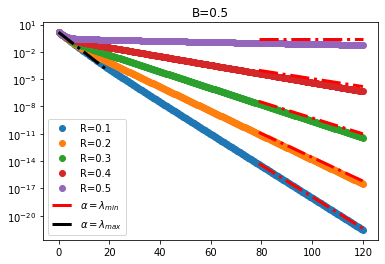

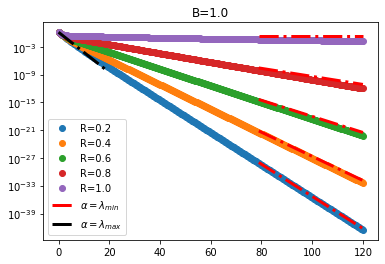

In [101]:
T = 50
K = 200

for k, A in enumerate(params_a):

    plt.figure(figsize=(6,4))

    plt.title('B='+str(A))

    for i in range(k*5, (k+1)*5):
        plt.plot(times, dist_t[i], 'o', label='R='+str(round(params[i][1],2)))
        
        coef = np.polyfit(times[K:], np.log(dist_t[i][K:]), deg=1)
        #print(-coef[0], eigvals[i][0].real)
        
        if i==(k+1)*5-1:
            plt.plot(times[K:], np.exp(coef[1])*np.exp(-times[K:]*eigvals[i][0].real), '-.', c='r', zorder=10, label=r'$\alpha=\lambda_{min}$')
            #plt.plot(times[K:], np.exp(coef[1])*np.exp(times[K:]*coef[0]), '-.', c='k', zorder=10, label=r'$\alpha=\lambda_{min}=R-B$')
        else:
            plt.plot(times[K:], np.exp(coef[1])*np.exp(-times[K:]*eigvals[i][0].real), '-.', c='r', zorder=10)
            #plt.plot(times[K:], np.exp(coef[1])*np.exp(times[K:]*coef[0]), '-.', c='k', zorder=10)
    
    plt.plot(times[:T], np.sqrt(2)*np.exp(-times[:T]*A), '-.', c='k', label=r'$\alpha=\lambda_{max}$')
    
    plt.legend()
    plt.yscale('log')
    
plt.show()

In [35]:
param_2 = [0.2, 0.4, 0.6, 0.8, 1.]
param_1 = [0.2, 0.5, 1.]
param = [[a, a*b] for a in param_1 for b in param_2]

param_1_name = 'B'
param_2_name = 'R/B'
param_name = [param_1_name+'='+str(a)+','+param_2_name+'='+str(b) for a in param_1 for b in param_2]
param_rows = [param_1_name+'='+str(a) for a in param_1]
param_cols = [param_2_name+'='+str(b) for b in param_2]

dist_t, avg_dist_t, eigvals, times = Simu_diffu_params(G_gn, infoG_gn, param, t_max = 1, t_n = 1)

-------- GRAPH DISTANCES --------
[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.04000000000000001]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.08000000000000002]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.12]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.16000000000000003]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.2, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.1]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.3]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.4]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0.5, 0.5]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.4]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.6]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 0.8]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [1.0, 1.0]
Evaluating jacobian distance...


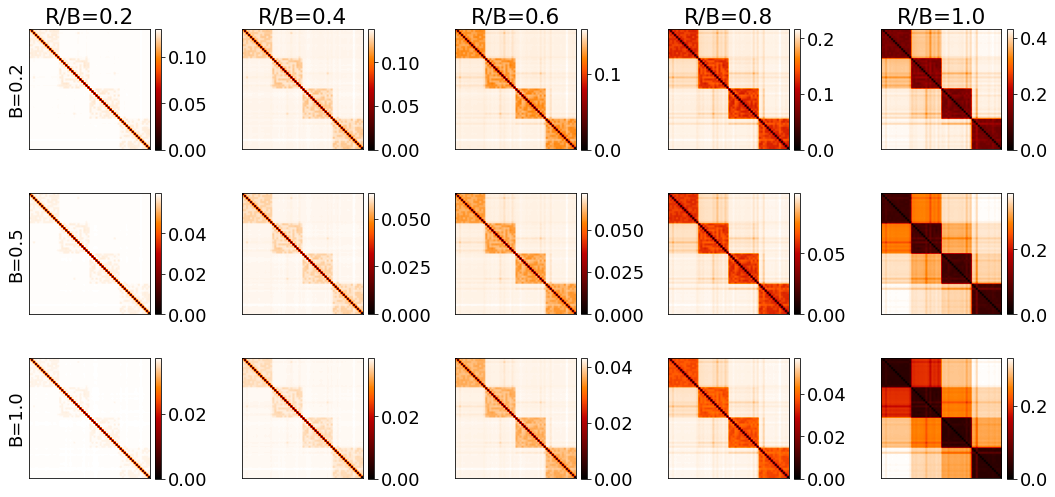

In [36]:
plotter.plot_average_dist_matrix_square(avg_dist_t, param_rows, param_cols, hspace=-1.05, norm = False)

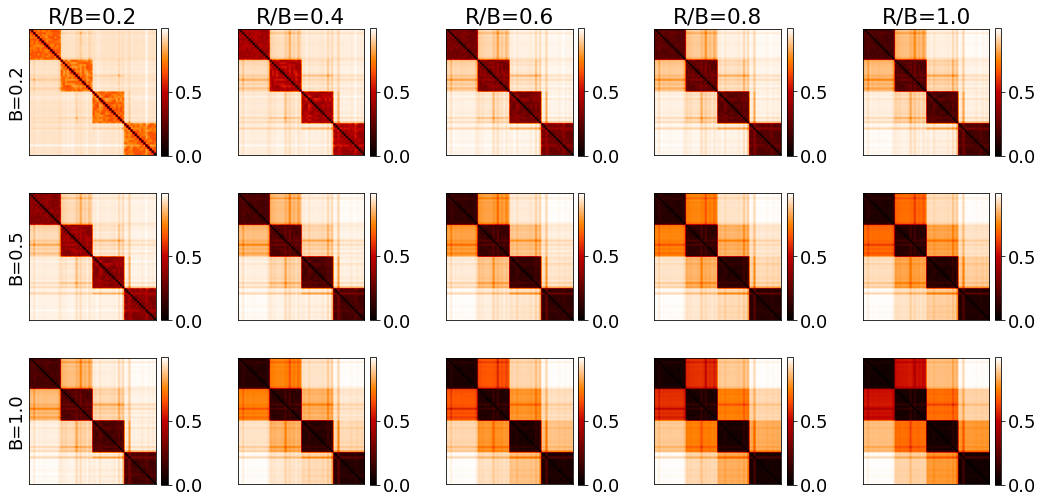

In [37]:
plotter.plot_average_dist_matrix_square(avg_dist_t, param_rows, param_cols, hspace=-1.05, norm = True)

In [ ]:
plotter.plot_dist_matrix_evol(avg_dist_t, cf.dynamics_list, hspace=-0.7)

### If also R is negative...

In [40]:
param_2 = [0.2, 0.4, 0.6, 0.8, 1.]
param_1 = [0.2, 0.5, 1.]
param = [[a, -a*b] for a in param_1 for b in param_2]

param_1_name = 'B'
param_2_name = 'R/B'
param_name = [param_1_name+'='+str(a)+','+param_2_name+'='+str(b) for a in param_1 for b in param_2]
param_rows = [param_1_name+'='+str(a) for a in param_1]
param_cols = [param_2_name+'='+str(-b) for b in param_2]

#dist_t, avg_dist_t, eigvals, times = Simu_diffu_params(G_gn, infoG_gn, params)

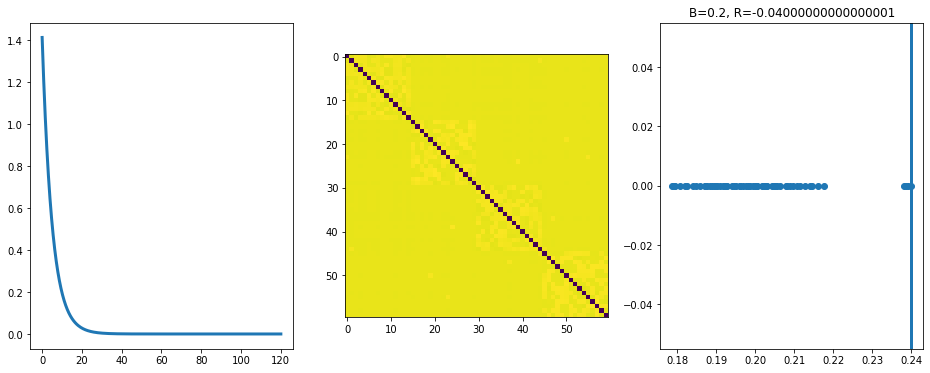

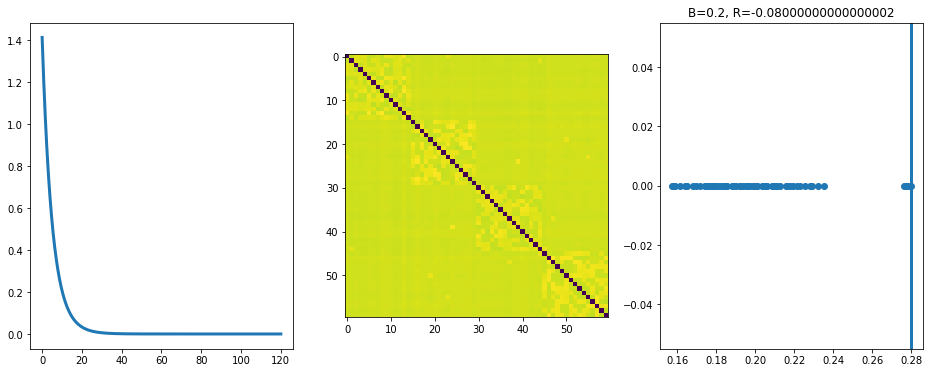

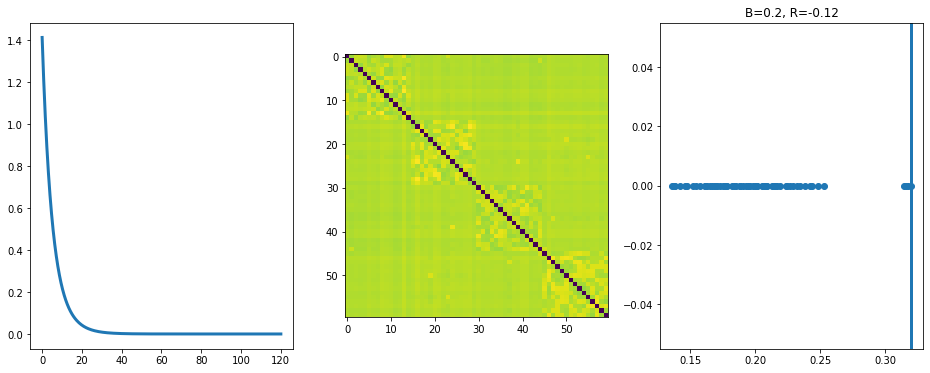

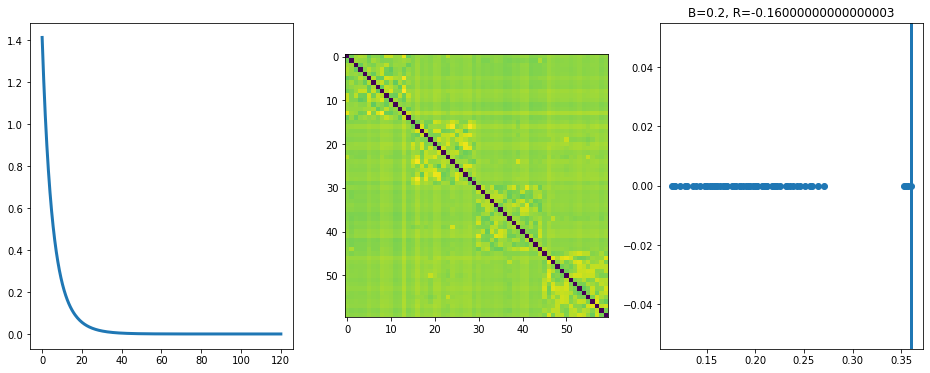

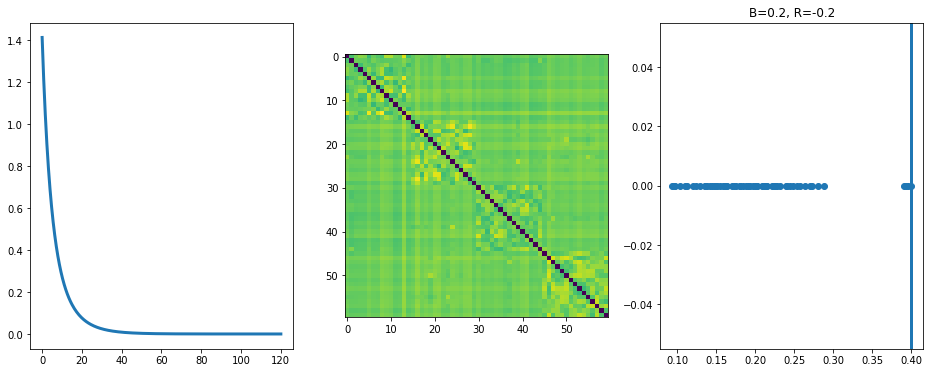

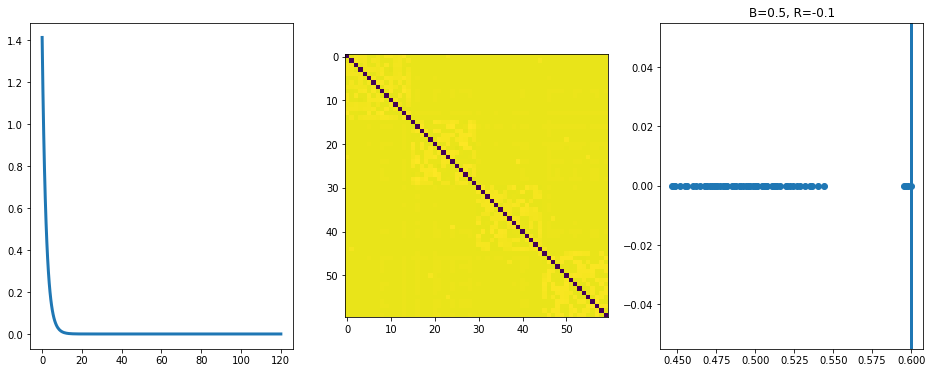

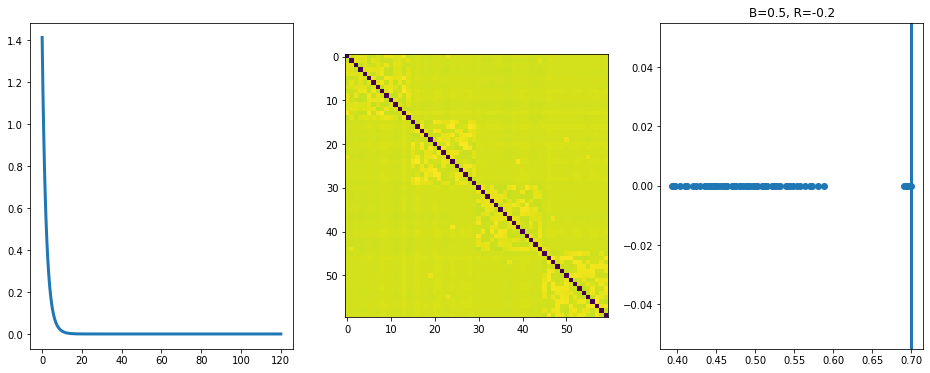

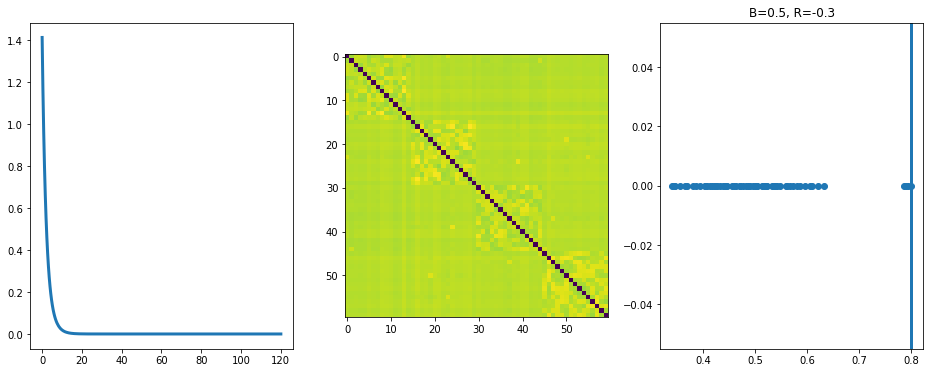

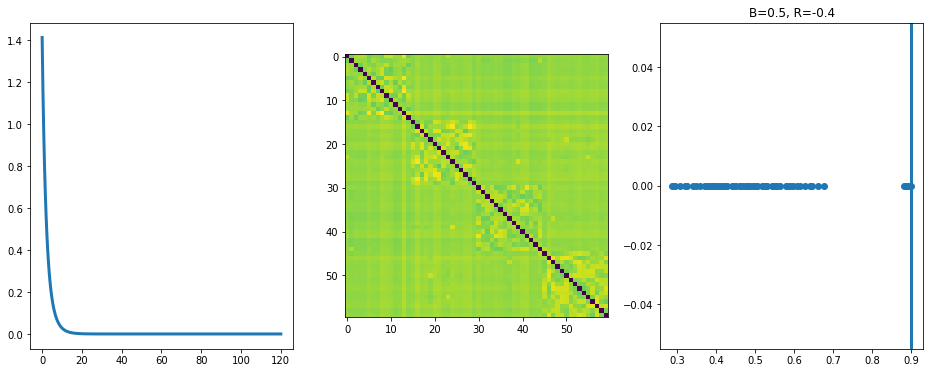

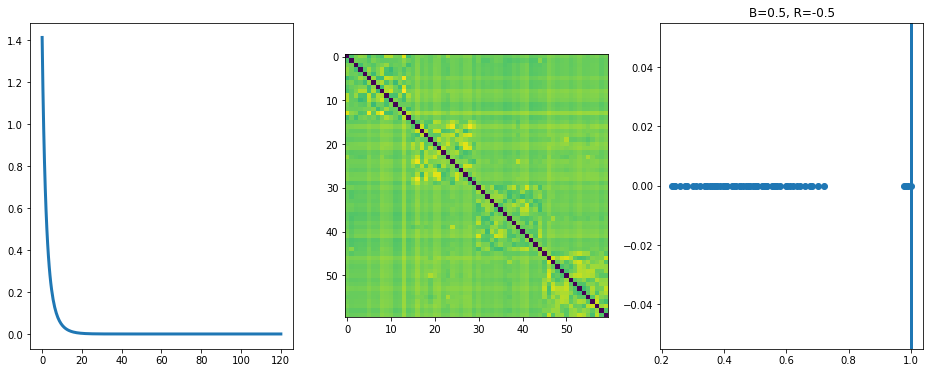

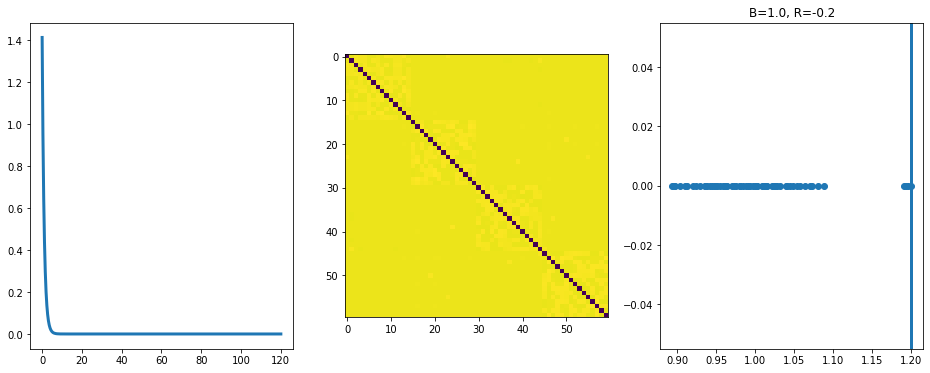

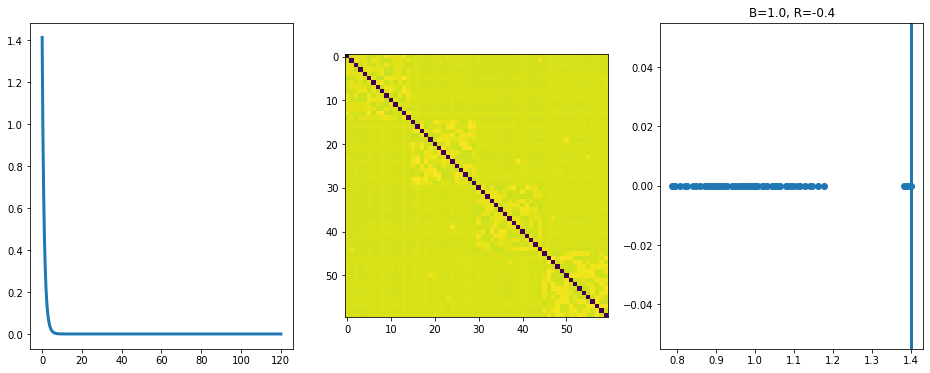

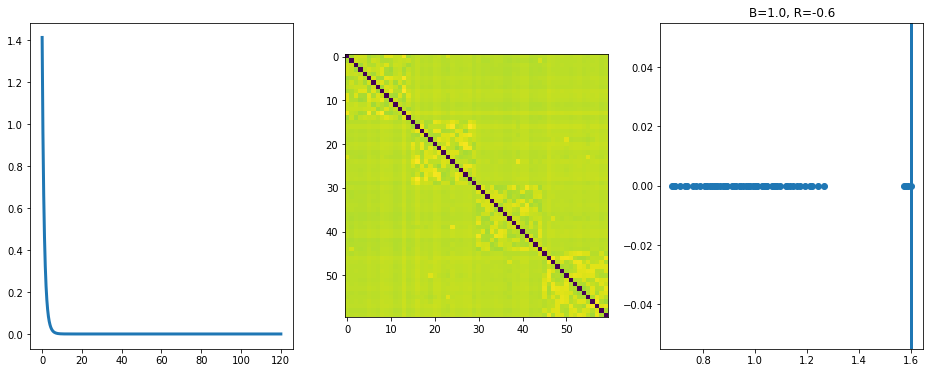

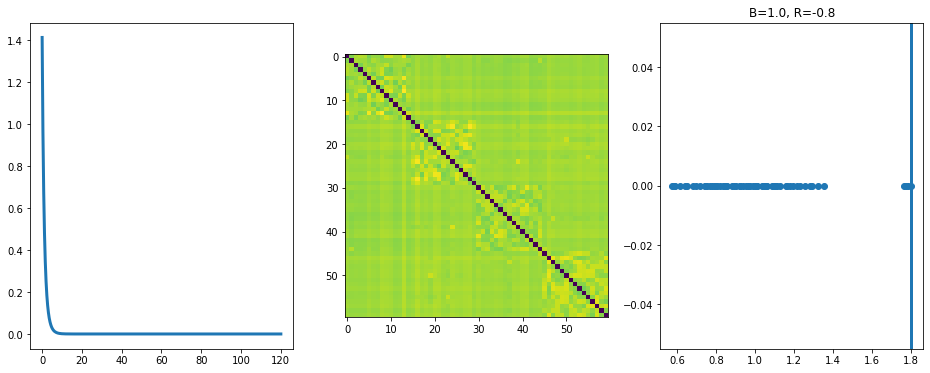

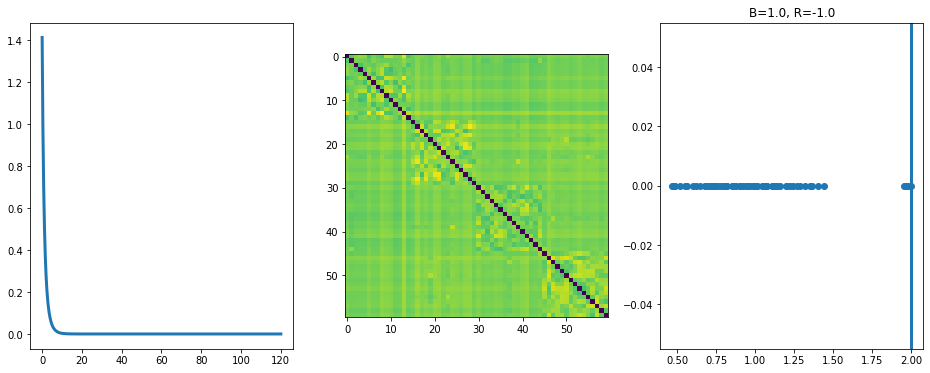

In [105]:
for i, param in enumerate(params):
    plt.figure(figsize=(16,6))
    
    ### Average distance vs time
    plt.subplot(1,3,1)
    plt.plot(times, dist_t[i])
    
    ### Average distance matrix
    plt.subplot(1,3,2)
    plt.imshow(cf.get_average_distance_matrix(avg_dist_t[i]))
    
    ### Eigvals
    plt.subplot(1,3,3)
    plt.plot(eigvals[i].real, eigvals[i].imag, 'o')
    plt.axvline(param[0]-param[1])
    
    plt.title('B='+str(param[0])+', R='+str(param[1]))
    
plt.show()

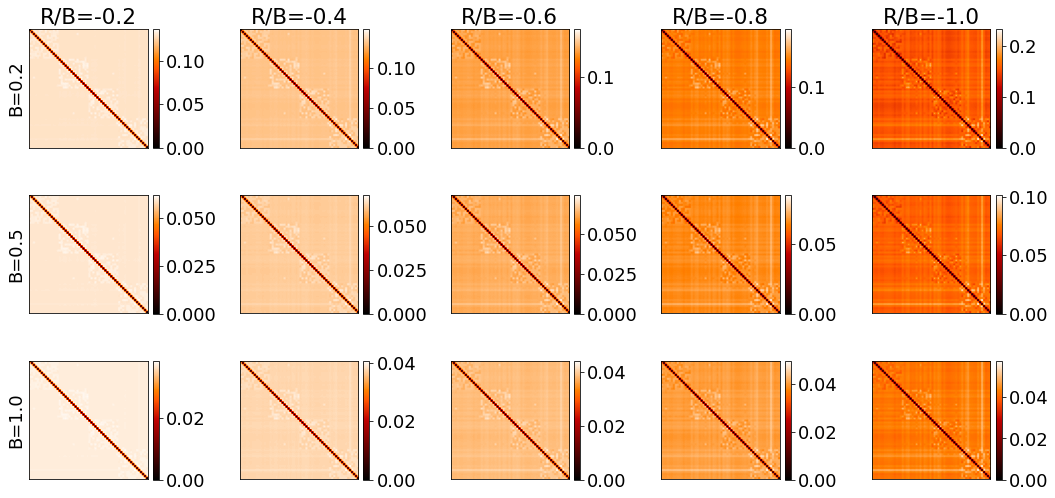

In [41]:
plotter.plot_average_dist_matrix_square(avg_dist_t, param_rows, param_cols, hspace=-1.05, norm = False)

### If B=0...

In [106]:
params_b = [0.2, 0.4, 0.6, 0.8, 1.]
params_a = [0]
params = [[a, -b] for a in params_a for b in params_b]

dist_t, avg_dist_t, eigvals, times = Simu_diffu_params(G_gn, infoG_gn, params)

-------- GRAPH DISTANCES --------
[*] DIFFUSION DISTANCE - PARAMS: [0, -0.2]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0, -0.4]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0, -0.6]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0, -0.8]
Evaluating jacobian distance...



[*] DIFFUSION DISTANCE - PARAMS: [0, -1.0]
Evaluating jacobian distance...


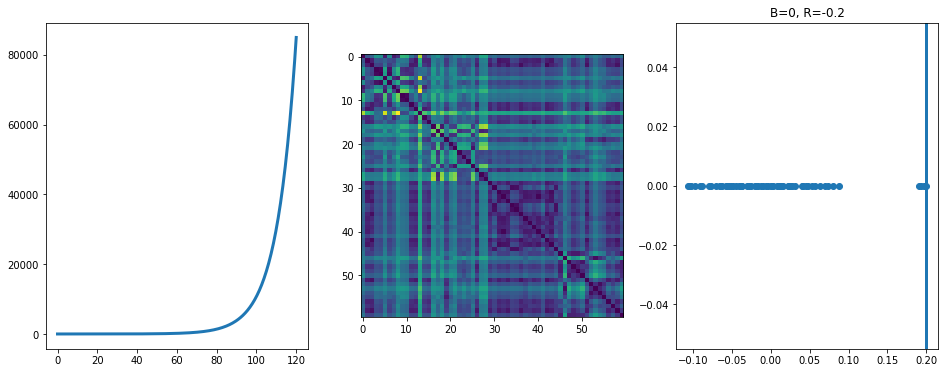

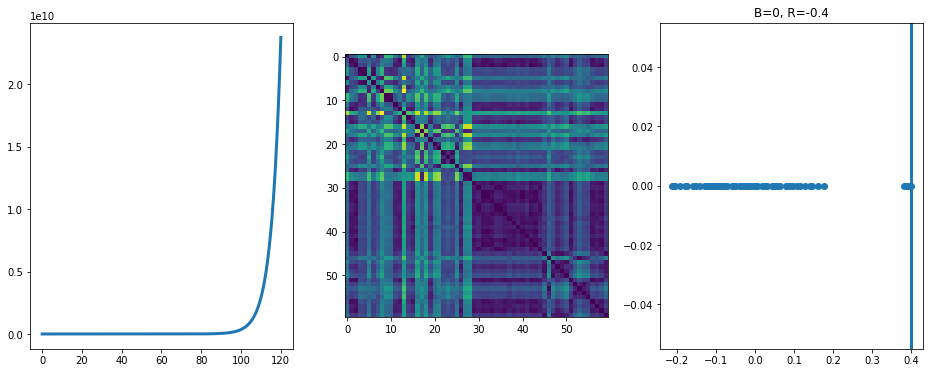

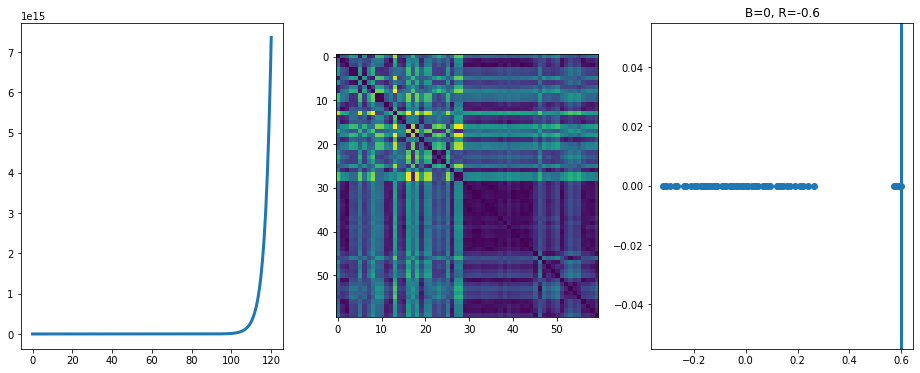

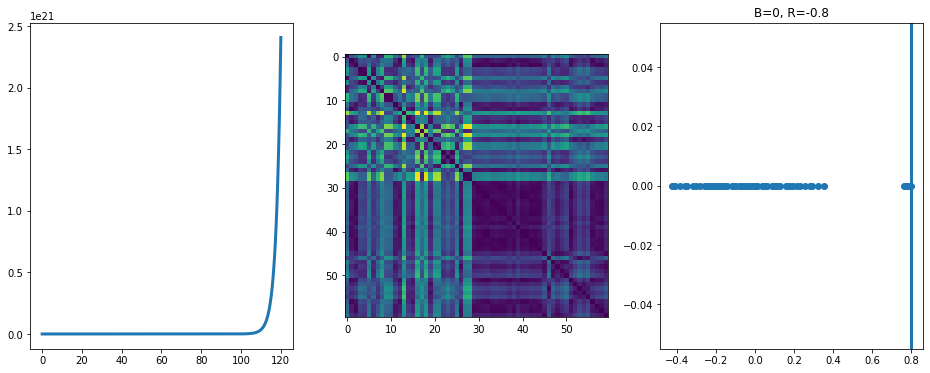

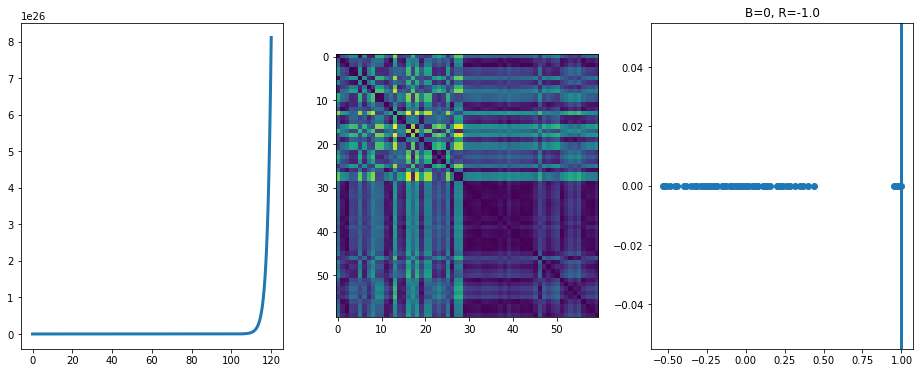

In [107]:
for i, param in enumerate(params):
    plt.figure(figsize=(16,6))
    
    ### Average distance vs time
    plt.subplot(1,3,1)
    plt.plot(times, dist_t[i])
    
    ### Average distance matrix
    plt.subplot(1,3,2)
    plt.imshow(cf.get_average_distance_matrix(avg_dist_t[i]))
    
    ### Eigvals
    plt.subplot(1,3,3)
    plt.plot(eigvals[i].real, eigvals[i].imag, 'o')
    plt.axvline(param[0]-param[1])
    
    plt.title('B='+str(param[0])+', R='+str(param[1]))
    
plt.show()